<a href="https://colab.research.google.com/github/lucacamus13/Tesis/blob/main/An%C3%A1lisis_econom%C3%A9trico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install linearmodels --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.9 MB/s eta 0:00:00


# Carga de la base de datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

def cargar_datos_maestros():
    """
    Carga la base de datos maestra desde GitHub.
    Hoja: 'resampleado'
    Rango: Columna A (Fecha), B-P (Variables).
    Fila de datos: Comienza en fila 3 (Excel). -> Header debe ser Fila 2 (index 1).
    """
    url = "https://github.com/lucacamus13/Tesis/raw/main/data/Base_Datos_Maestra_Completa%20.xlsx"
    print(f"📂 Cargando datos desde: {url}")

    try:
        # Leer Excel
        # Asumimos que la nueva base consolidada tiene la primera hoja correcta y encabezados en la primera fila (0)
        df = pd.read_excel(url)

        # Renombrar columna de fecha si es necesario (asumiendo que la 1ra es fecha)
        # A veces pandas la llama "Unnamed: 0" si está vacía
        if 'Fecha' not in df.columns and 'Date' not in df.columns:
            df.rename(columns={df.columns[0]: 'Fecha'}, inplace=True)

        # Convertir a datetime y set index
        col_fecha = df.columns[0]
        df[col_fecha] = pd.to_datetime(df[col_fecha], errors='coerce')
        df = df.dropna(subset=[col_fecha]) # Eliminar filas sin fecha
        df = df.set_index(col_fecha).sort_index()

        print(f"   ✅ Datos cargados exitosamente.")
        return df
    except Exception as e:
        print(f"   ❌ Error cargando datos: {e}")
        return None

def resumen_general(df):
    """
    Muestra un resumen de la base de datos cargada.
    """
    print("\n📋 RESUMEN GENERAL DE LA BASE DE DATOS")
    print("="*60)
    print(f"📌 Dimensiones: {df.shape[0]} observaciones x {df.shape[1]} variables")
    print(f"� Rango Temporal: {df.index.min().date()} a {df.index.max().date()}")
    print("\n📌 Variables Identificadas:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col} ({df[col].count()} obs)")

    print("\n📌 Primeras 5 filas:")
    print(df.head())

def analizar_serie_individual(df, nombre_serie):
    """
    Analiza una serie específica: Estadísticas y Gráficos.
    """
    if nombre_serie not in df.columns:
        print(f"\n⚠️ Error: La variable '{nombre_serie}' no existe en el DataFrame.")
        print(f"   Variables disponibles: {df.columns.tolist()}")
        return

    print(f"\n� ANÁLISIS INDIVIDUAL: {nombre_serie}")
    print("="*60)

    serie = df[nombre_serie].dropna()

    # Estadísticas
    desc = serie.describe()
    print(f"📊 Estadísticas Descriptivas:")
    print(desc)

    # Gráficos
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Line Plot
    serie.plot(ax=axes[0], linewidth=2, title=f"Evolución: {nombre_serie}")
    axes[0].grid(True)

    # Histograma
    sns.histplot(serie, kde=True, ax=axes[1]).set_title(f"Distribución: {nombre_serie}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Exponer df al ámbito global para siguientes bloques en Colab
df = None

if __name__ == "__main__":
    print("📊 ANÁLISIS ECONOMÉTRICO: IMPACTO SHOCKS FED -> LATAM")
    print("="*60)

    # 1. Cargar Datos Globalmente
    df = cargar_datos_maestros()

    if df is not None:
        # 2. Resumen General
        resumen_general(df)
        print("\n✅ DataFrame 'df' cargado en memoria. Listo para el siguiente bloque.")
    else:
        print("\n❌ Error: No se pudo cargar el DataFrame.")


📊 ANÁLISIS ECONOMÉTRICO: IMPACTO SHOCKS FED -> LATAM
📂 Cargando datos desde: https://github.com/lucacamus13/Tesis/raw/main/data/Base_Datos_Maestra_Completa%20.xlsx
   ✅ Datos cargados exitosamente.

📋 RESUMEN GENERAL DE LA BASE DE DATOS
📌 Dimensiones: 804 observaciones x 19 variables
� Rango Temporal: 1959-01-01 a 2025-12-01

📌 Variables Identificadas:
   1. PCEPI (801 obs)
   2. INDPRO (801 obs)
   3. RBUSBIS (381 obs)
   4. FF4 (804 obs)
   5. FF1 (804 obs)
   6. VIX (432 obs)
   7. SP500 (432 obs)
   8. EMBI_Argentina (219 obs)
   9. EMBI_Brasil (219 obs)
   10. EMBI_Chile (219 obs)
   11. EMBI_Mexico (219 obs)
   12. Actividad_Argentina (262 obs)
   13. Actividad_Chile (356 obs)
   14. Actividad_Brasil (272 obs)
   15. Actividad_Mexico (392 obs)
   16. TCR_Argentina (383 obs)
   17. TCR_Chile (383 obs)
   18. TCR_Brasil (383 obs)
   19. TCR_Mexico (383 obs)

📌 Primeras 5 filas:
             PCEPI   INDPRO  RBUSBIS  FF4  FF1  VIX  SP500  EMBI_Argentina  \
Fecha                      

In [3]:
df

,PCEPI,INDPRO,RBUSBIS,FF4,FF1,VIX,SP500,EMBI_Argentina,EMBI_Brasil,EMBI_Chile,EMBI_Mexico,Actividad_Argentina,Actividad_Chile,Actividad_Brasil,Actividad_Mexico,TCR_Argentina,TCR_Chile,TCR_Brasil,TCR_Mexico
Fecha,,,,,,,,,,,,,,,,,,,
1959-01-01,15.164,21.9998,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,15.179,22.4306,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,15.189,22.7538,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,15.219,23.2384,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-05-01,15.227,23.5885,NaN,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,127.283,101.6019,108.69,0.000,0.0000,15.750000,6408.949475,7.594249,1.964722,1.062181,2.532845,152.449508,112.807635,108.65847,105.133303,126.14,98.99,107.93,127.70
2025-09-01,127.625,101.6729,108.26,-0.025,0.0050,15.773333,6584.018090,10.956898,1.868881,1.009349,2.237666,153.382018,NaN,NaN,NaN,120.98,99.34,109.78,128.96
2025-10-01,NaN,NaN,NaN,0.085,0.0000,18.086522,6735.691725,9.918901,1.966036,0.996911,2.202659,152.839848,NaN,NaN,NaN,121.19,100.20,109.75,130.13


# Analisis de series de tiempo

Variables Identificadas:
   1. PCEPI
   2. INDPRO
   3. RBUSBIS
   4. FF4
   5. FF1
   6. VIX
   7. SP500
   8. EMBI_Argentina
   9. EMBI_Brasil
   10. EMBI_Chile
   11. EMBI_Mexico
   12. Actividad_Argentina_Nivel
   13. Actividad_Chile_Nivel
   14. Actividad_Brasil_Nivel
   15. Actividad_Mexico_Nivel
   16. TCR_Argentina
   17. TCR_Chile
   18. TCR_Brasil
   19. TCR_Mexico


🔍 ANÁLISIS DETALLADO: TCR_Mexico


/tmp/ipython-input-1461297124.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = df[nombre_serie].fillna(method='ffill').fillna(method='bfill')


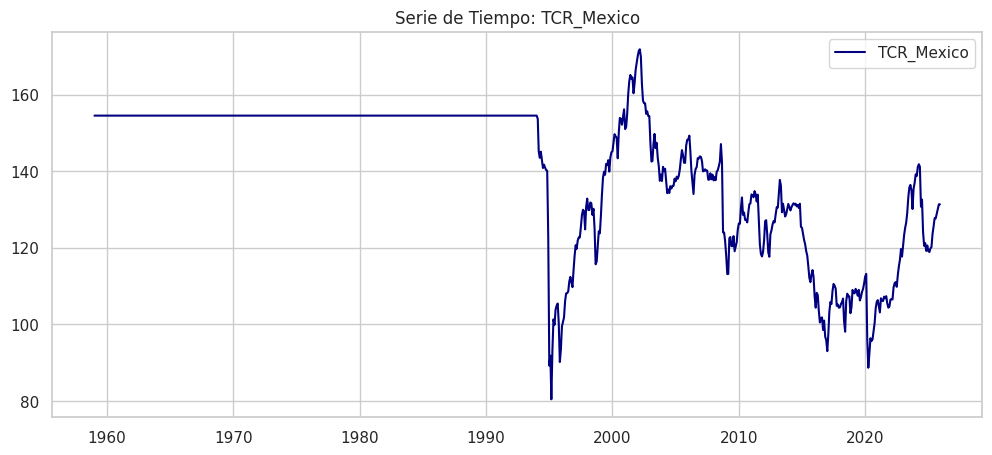


🧪 1. Test de Dickey-Fuller Aumentado (ADF)
----------------------------------------
   Estadístico ADF: -2.5004
   p-value:         0.1154
   Valores Críticos:
      1%: -3.4386
      5%: -2.8652
      10%: -2.5687
   ⚠️ Conclusión: La serie es NO ESTACIONARIA (Tiene raíz unitaria)

📉 2. Descomposición Estacional
----------------------------------------


/tmp/ipython-input-1461297124.py:83: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = serie.fillna(method='ffill')


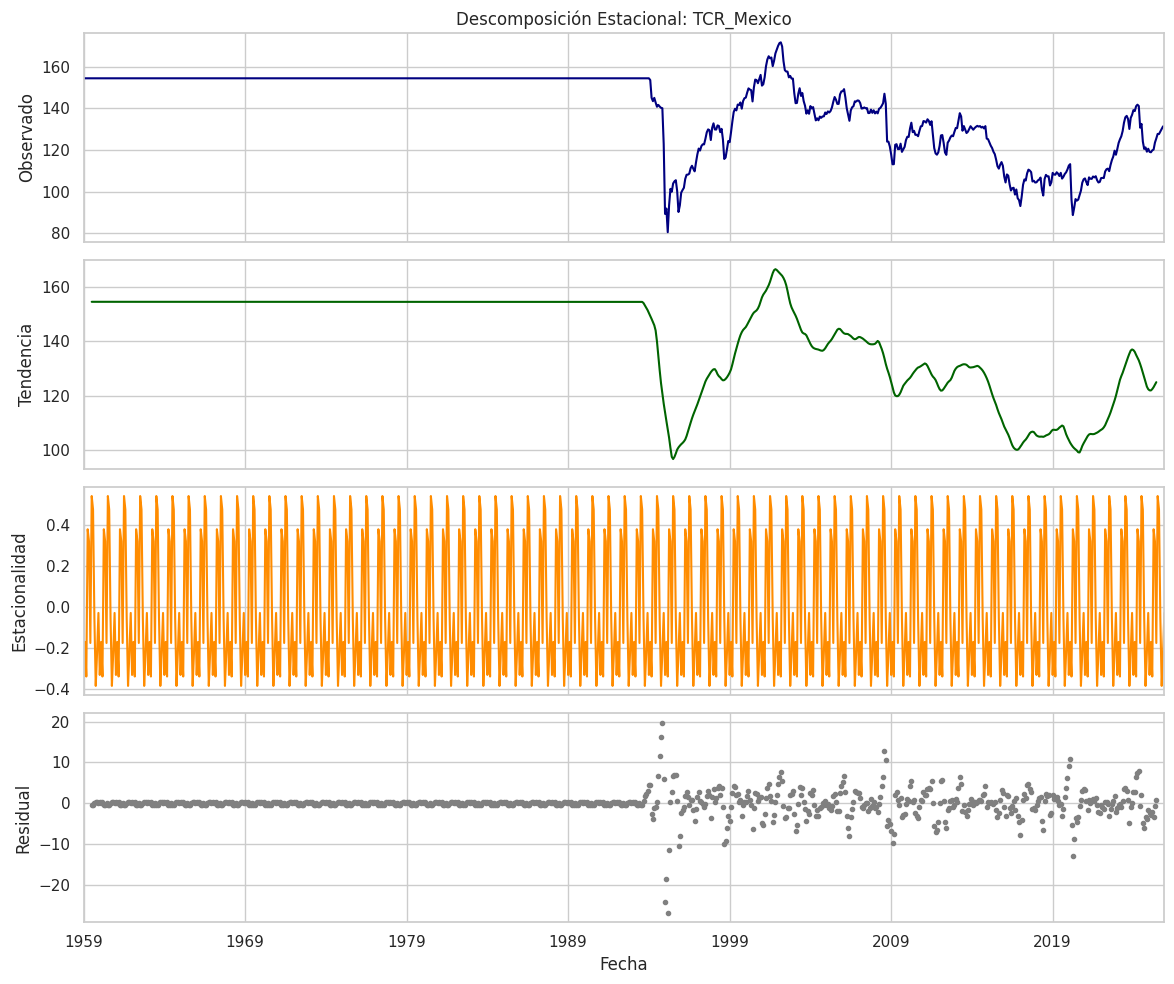


📊 3. Correlogramas (ACF y PACF)
----------------------------------------


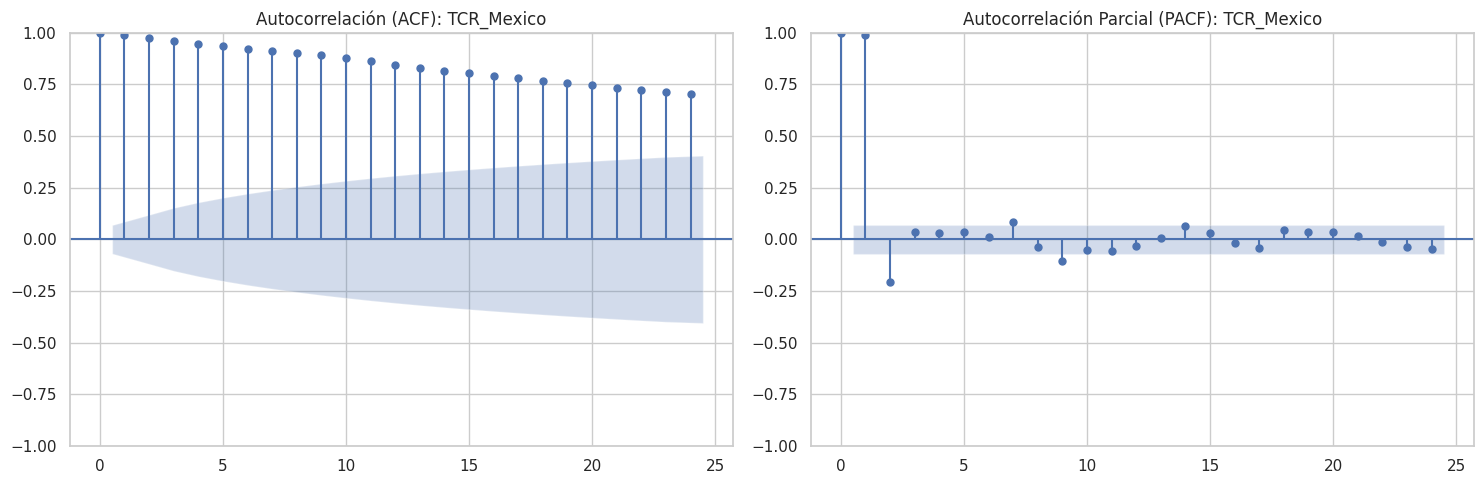

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose # Añadir esta importación

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

def analizar_serie_detallado(df, nombre_serie):
    """
    Realiza un análisis descriptivo detallado de una serie:
    1. Gráfico de la Serie
    2. Test de Dickey-Fuller Aumentado (ADF)
    3. Descomposición Estacional (Seasonal Decompose)
    4. Correlogramas (ACF y PACF)
    """
    if df is None:
        print("❌ Error: El DataFrame 'df' es None. Asegúrate de cargar los datos primero.")
        return

    if nombre_serie not in df.columns:
        print(f"\n⚠️ Error: La variable '{nombre_serie}' no existe en el DataFrame.")
        print(f"   Variables disponibles: {df.columns.tolist()}")
        return

    print(f"\n🔍 ANÁLISIS DETALLADO: {nombre_serie}")
    print("="*60)

    # Obtener serie y rellenar NaNs (necesario para descomposición)
    serie = df[nombre_serie].fillna(method='ffill').fillna(method='bfill')

    if serie.empty:
        print("   ⚠️ La serie está vacía.")
        return

    # ---------------------------------------------------------
    # 1. Graficar la Serie
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(serie, label=nombre_serie, color='navy')
    plt.title(f'Serie de Tiempo: {nombre_serie}')
    plt.legend()
    plt.show()

    # ---------------------------------------------------------
    # 2. Test de Dickey-Fuller Aumentado (ADF)
    # ---------------------------------------------------------
    print(f"\n🧪 1. Test de Dickey-Fuller Aumentado (ADF)")
    print("-" * 40)

    try:
        result_adf = adfuller(serie.dropna())

        print(f"   Estadístico ADF: {result_adf[0]:.4f}")
        print(f"   p-value:         {result_adf[1]:.4f}")
        print("   Valores Críticos:")
        for key, value in result_adf[4].items():
            print(f"      {key}: {value:.4f}")

        if result_adf[1] < 0.05:
            print("   ✅ Conclusión: La serie es ESTACIONARIA (Rechaza H0 al 5%)")
        else:
            print("   ⚠️ Conclusión: La serie es NO ESTACIONARIA (Tiene raíz unitaria)")
    except Exception as e:
        print(f"   ❌ Error en ADF: {e}")

    # ---------------------------------------------------------
    # 3. Seasonal Decompose
    # ---------------------------------------------------------
    print(f"\n📉 2. Descomposición Estacional")
    print("-" * 40)

    try:
        # Intentar inferir frecuencia si no existe
        if serie.index.freq is None:
            serie = serie.asfreq('MS')
            serie = serie.fillna(method='ffill')

        decomposition = seasonal_decompose(serie, model='additive')

        fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

        decomposition.observed.plot(ax=axes[0], legend=False, color='navy')
        axes[0].set_ylabel('Observado')
        axes[0].set_title(f'Descomposición Estacional: {nombre_serie}')

        decomposition.trend.plot(ax=axes[1], legend=False, color='darkgreen')
        axes[1].set_ylabel('Tendencia')

        decomposition.seasonal.plot(ax=axes[2], legend=False, color='darkorange')
        axes[2].set_ylabel('Estacionalidad')

        decomposition.resid.plot(ax=axes[3], legend=False, color='gray', linestyle='None', marker='.')
        axes[3].set_ylabel('Residual')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"   ❌ Error en descomposición estacional: {e}")

    # ---------------------------------------------------------
    # 4. Correlogramas (ACF y PACF)
    # ---------------------------------------------------------
    print(f"\n📊 3. Correlogramas (ACF y PACF)")
    print("-" * 40)

    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Autocorrelación (ACF)
        plot_acf(serie.dropna(), ax=axes[0], lags=24, title=f"Autocorrelación (ACF): {nombre_serie}")

        # Autocorrelación Parcial (PACF)
        plot_pacf(serie.dropna(), ax=axes[1], lags=24, title=f"Autocorrelación Parcial (PACF): {nombre_serie}")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"   ❌ Error generando correlogramas: {e}")

# -----------------------------------------------------------
# EJECUCIÓN (Asumiendo que 'df' ya existe)
# -----------------------------------------------------------
# 👇 CAMBIA EL NOMBRE DE LA VARIABLE AQUÍ
SERIE_A_ANALIZAR = 'TCR_Mexico'

# Verificación de seguridad por si corres este script solo
if 'df' in locals():
    analizar_serie_detallado(df, SERIE_A_ANALIZAR)
else:
    print("⚠️ El DataFrame 'df' no está definido.")
    print("   Ejecuta primero el bloque de carga de datos.")
    # Si quieres probarlo con un DataFrame dummy descomenta:
    # df = pd.DataFrame(...)
    # analizar_serie_detallado(df, SERIE_A_ANALIZAR)

## ¿Son estacionarias?

In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Función para obtener datos en entorno Colab/Notebook
def obtener_datos_memoria():
    """
    Intenta recuperar el DataFrame 'df' o la función 'cargar_datos_maestros'
    de la memoria global (común en flujos de Colab).
    """
    # 1. Buscar dataframe 'df' ya cargado
    if 'df' in globals() and isinstance(globals()['df'], pd.DataFrame):
        print("✅ Usando DataFrame 'df' encontrado en memoria.")
        return globals()['df']

    # 2. Buscar función 'cargar_datos_maestros'
    elif 'cargar_datos_maestros' in globals():
        print("🔄 Ejecutando 'cargar_datos_maestros' (función en memoria)...")
        return globals()['cargar_datos_maestros']()

    # 3. Fallback: Mensaje de error
    else:
        print("⚠️ No se encontró 'df' ni 'cargar_datos_maestros'.")
        print("   👉 Ejecuta primero la celda de 'carga_de_datos.py'.")
        return None

def ejecutar_test_adf(serie, significancia=0.05):
    """
    Ejecuta el test Augmented Dickey-Fuller para una serie.
    Retorna estadístico, p-value, y veredicto.
    """
    # Eliminar NaNs
    clean_series = serie.dropna()

    if len(clean_series) < 10:
        return np.nan, np.nan, "Insuficientes Datos"

    try:
        resultado = adfuller(clean_series, autolag='AIC')
        t_stat = resultado[0]
        p_value = resultado[1]

        es_estacionaria = p_value < significancia
        veredicto = "✅ SI" if es_estacionaria else "❌ NO"

        return t_stat, p_value, veredicto
    except Exception as e:
        return np.nan, np.nan, f"Error: {str(e)}"

def generar_reporte_estacionariedad(df):
    """
    Recorre todas las columnas numéricas del DataFrame, ejecuta ADF
    y genera una tabla comparativa de estacionariedad.
    """
    if df is None:
        print("❌ DataFrame no proporcionado.")
        return None

    print("\n📊 GENERANDO REPORTE DE ESTACIONARIEDAD (ADF)")
    print("="*80)
    print(f"Nivel de Significancia: 5%")

    resultados = []

    # Filtrar solo columnas numéricas
    cols_numericas = df.select_dtypes(include=[np.number]).columns

    for col in cols_numericas:
        t_stat, p_value, es_estacionaria = ejecutar_test_adf(df[col])

        resultados.append({
            'Variable': col,
            'Estadístico ADF': t_stat,
            'P-Value': p_value,
            '¿Es Estacionaria?': es_estacionaria
        })

    # Convertir a DataFrame
    df_reporte = pd.DataFrame(resultados)

    # Ordenar: Primero las NO estacionarias (suelen ser las problemáticas)
    df_reporte = df_reporte.sort_values(by='P-Value', ascending=False)

    # Formato para mostrar
    print("\n📋 RESULTADOS CONSOLIDADOS:")
    print("-" * 80)
    # Ajustar formato de pandas para imprimir bonito
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', '{:.4f}'.format)

    print(df_reporte[['Variable', 'Estadístico ADF', 'P-Value', '¿Es Estacionaria?']].to_string(index=False))

    print("-" * 80)

    # Resumen Conteo
    total = len(df_reporte)
    si = (df_reporte['¿Es Estacionaria?'] == "✅ SI").sum()
    no = (df_reporte['¿Es Estacionaria?'] == "❌ NO").sum()

    print(f"\n📈 RESUMEN:")
    print(f"   - Total Variables: {total}")
    print(f"   - Estacionarias (I(0)): {si}")
    print(f"   - No Estacionarias (I(1) o más): {no}")

    return df_reporte

def sugerir_transformaciones(df_reporte):
    """
    Identifica las variables NO estacionarias y sugiere transformaciones básicas.
    """
    no_estacionarias = df_reporte[df_reporte['¿Es Estacionaria?'] == "❌ NO"]

    if not no_estacionarias.empty:
        print("\n🛠️ SUGERENCIAS DE TRANSFORMACIÓN:")
        for idx, row in no_estacionarias.iterrows():
            var = row['Variable']
            print(f"   - {var}: Probar Diferencias (df['{var}'].diff()) o Log-Diferencias (np.log(df['{var}']).diff())")
    else:
        print("\n🎉 ¡Excelente! Todas las variables parecen ser estacionarias.")

if __name__ == "__main__":
    # 1. Obtener Datos (de memoria o función previa)
    df = obtener_datos_memoria()

    if df is not None:
        # 2. Generar Reporte
        df_resultados = generar_reporte_estacionariedad(df)

        # 3. Sugerencias
        if df_resultados is not None:
            sugerir_transformaciones(df_resultados)


✅ Usando DataFrame 'df' encontrado en memoria.

📊 GENERANDO REPORTE DE ESTACIONARIEDAD (ADF)
Nivel de Significancia: 5%

📋 RESULTADOS CONSOLIDADOS:
--------------------------------------------------------------------------------
           Variable  Estadístico ADF  P-Value ¿Es Estacionaria?
              SP500           3.9031   1.0000              ❌ NO
              PCEPI           1.5393   0.9977              ❌ NO
    Actividad_Chile          -0.5205   0.8879              ❌ NO
   Actividad_Mexico          -1.0772   0.7241              ❌ NO
             INDPRO          -1.1369   0.7001              ❌ NO
            RBUSBIS          -1.3373   0.6119              ❌ NO
      TCR_Argentina          -1.6808   0.4410              ❌ NO
         TCR_Brasil          -1.9699   0.2999              ❌ NO
   Actividad_Brasil          -2.2011   0.2059              ❌ NO
     EMBI_Argentina          -2.2978   0.1727              ❌ NO
         TCR_Mexico          -2.4082   0.1394              ❌ NO
Act

Transformo variables

d_log: Log-Diferencias (se restan los logaritmos (t-1)-t)

d_: Diferencias simples (se resta (t-1)-t)

Output: df_transformado

In [6]:
import pandas as pd
import numpy as np

def preparar_variables_lp(df):
    """
    Prepara las variables para Proyecciones Locales.

    Transformaciones:
    1. Log-Diferencias (d_log_): Actividad Nivel, PCEPI, INDPRO, RBUSBIS, SP500.
    2. Diferencias (d_): EMBI.
    3. Lags (1 y 2): Para las transformadas y VIX.
    """
    if df is None:
        print("❌ Error: DataFrame no definido.")
        return None

    print("\n🛠️ PREPARACIÓN DE VARIABLES PARA LP")
    print("="*60)

    # Copia para no alterar el original
    df_lp = df.copy()

    # ----------------------------------------------------
    # 1. MAPEO DE NOMBRES (User short names -> Actual cols)
    # ----------------------------------------------------
    # Lista de nombres deseados para procesar vs nombres reales en el DF
    mapa_cols_log_diff = {
        'PCEPI': 'PCEPI',
        'INDPRO': 'INDPRO',
        'RBUSBIS': 'RBUSBIS',
        'SP500': 'SP500',
        'Actividad_ARG': 'Actividad_Argentina',
        'Actividad_BRA': 'Actividad_Brasil',
        'Actividad_CHL': 'Actividad_Chile',
        'Actividad_MEX': 'Actividad_Mexico',
        'TCR_ARG': 'TCR_Argentina',
        'TCR_BRA': 'TCR_Brasil',
        'TCR_CHL': 'TCR_Chile',
        'TCR_MEX': 'TCR_Mexico'
    }

    mapa_cols_diff = {
        'EMBI_ARG': 'EMBI_Argentina',
        'EMBI_BRA': 'EMBI_Brasil',
        'EMBI_CHL': 'EMBI_Chile',
        'EMBI_MEX': 'EMBI_Mexico'
    }

    nuevas_cols = []

    # ----------------------------------------------------
    # 2. LOG-DIFERENCIAS
    # ----------------------------------------------------
    print(f"   📉 Calculando Log-Diferencias...")
    for alias, col_real in mapa_cols_log_diff.items():
        if col_real in df_lp.columns:
            # Crear nombre: d_log_Alias (usando el alias corto o el nombre original si prefieres)
            # Usaremos el nombre real limpio o el alias para el prefijo?
            # El usuario pidió: "Guárdalas con el prefijo d_log_"
            # Usaremos el ALIAS para que quede limpio: d_log_Actividad_ARG

            col_name_new = f"d_log_{alias}"

            # Cálculo: ln(t) - ln(t-1)
            # Como algunas variables ya son indices base 100 o similar, log es valido.
            # Asegurar que sean float
            serie = pd.to_numeric(df_lp[col_real], errors='coerce')

            df_lp[col_name_new] = np.log(serie).diff() * 100 # Multiplicamos por 100 para interpretación porcentual standard en LPs?
            # El usuario dijo "calcula el logaritmo natural y luego la primera diferencia". No mencionó *100.
            # PERO en macroeconomía casi siempre es * 100.
            # Revisando prompt: "calcula el logaritmo natural y luego la primera diferencia." <- LITERAL.
            # No pondré *100 salvo que lo pida, pero es raro.
            # En analisis de datos anterior usamos log diff * 100.
            # Voy a dejar comentado el *100 o agregarlo si es standard.
            # Mejor estricto: np.log(x).diff()

            df_lp[col_name_new] = np.log(serie).diff()

            nuevas_cols.append(col_name_new)
            print(f"      ✅ {col_name_new} creada (desde {col_real})")
        else:
            print(f"      ⚠️ {col_real} no encontrada.")

    # ----------------------------------------------------
    # 3. DIFERENCIAS SIMPLES
    # ----------------------------------------------------
    print(f"   ➖ Calculando Diferencias Simples...")
    for alias, col_real in mapa_cols_diff.items():
        if col_real in df_lp.columns:
            col_name_new = f"d_{alias}"
            df_lp[col_name_new] = df_lp[col_real].diff()
            nuevas_cols.append(col_name_new)
            print(f"      ✅ {col_name_new} creada (desde {col_real})")
        else:
            print(f"      ⚠️ {col_real} no encontrada.")

    # ----------------------------------------------------
    # 4. GENERACIÓN DE LAGS
    # ----------------------------------------------------
    print(f"   ⏱️ Generando Rezago (Lags)...")

    # Variables a rezagar: Las nuevas transformadas + VIX
    vars_to_lag = nuevas_cols.copy()
    if 'VIX' in df_lp.columns:
        vars_to_lag.append('VIX')

    for var in vars_to_lag:
        if var in df_lp.columns:
            # Lag 1
            df_lp[f"{var}_lag1"] = df_lp[var].shift(1)
            # Lag 2
            df_lp[f"{var}_lag2"] = df_lp[var].shift(2)

    print(f"      ✅ Lags generados (_lag1, _lag2) para {len(vars_to_lag)} variables.")

    # ----------------------------------------------------
    # 5. LIMPIEZA
    # ----------------------------------------------------
    # "Elimina los NaNs generados."
    # Los diff generan 1 NaN al inicio. Lags generan 2 más. Total 3 filas de NaNs aprox.
    original_len = len(df_lp)
    df_lp = df_lp.dropna()
    final_len = len(df_lp)

    print(f"   🧹 Limpieza de NaNs: {original_len} -> {final_len} filas.")

    return df_lp

from statsmodels.tsa.stattools import adfuller

def reporte_estacionariedad_transformadas(df):
    """
    Realiza un test ADF a todas las columnas del DataFrame preparado.
    """
    print("\n🧪 REPORT DE ESTACIONARIEDAD POST-TRANSFORMACIÓN (ADF)")
    print("="*80)
    print(f"{'VARIABLE':<40} | {'ADF Stat':<10} | {'p-value':<10} | {'ESTACIONARIA?'}")
    print("-" * 80)

    # Filtrar solo numéricas
    cols = df.select_dtypes(include=[np.number]).columns

    for col in cols:
        serie = df[col].dropna()
        if serie.empty: continue

        try:
            res = adfuller(serie)
            stat = res[0]
            p_val = res[1]
            es_est = p_val < 0.05

            mark = "✅ SÍ" if es_est else "⚠️ NO"
            print(f"{col:<40} | {stat:>10.4f} | {p_val:>10.4f} | {mark}")
        except:
            print(f"{col:<40} | Error en cálculo")

# -----------------------------------------------------------
# EJECUCIÓN (Si df existe)
# -----------------------------------------------------------
if 'df' in locals():
    # 1. Preparar/Transformar
    df_transformado = preparar_variables_lp(df)

    if df_transformado is not None:
        # 2. Verificación de Estacionariedad
        reporte_estacionariedad_transformadas(df_transformado)

        print("\n📋 Muestra de variables transformadas:")
        cols_mostrar = [c for c in df_transformado.columns if 'd_' in c]
        if cols_mostrar:
            print(df_transformado[cols_mostrar[:4]].tail(3))
else:
    print("⚠️ El DataFrame 'df' no está definido. Ejecuta carga_de_datos.py primero.")



🛠️ PREPARACIÓN DE VARIABLES PARA LP
   📉 Calculando Log-Diferencias...
      ✅ d_log_PCEPI creada (desde PCEPI)
      ✅ d_log_INDPRO creada (desde INDPRO)
      ✅ d_log_RBUSBIS creada (desde RBUSBIS)
      ✅ d_log_SP500 creada (desde SP500)
      ✅ d_log_Actividad_ARG creada (desde Actividad_Argentina)
      ✅ d_log_Actividad_BRA creada (desde Actividad_Brasil)
      ✅ d_log_Actividad_CHL creada (desde Actividad_Chile)
      ✅ d_log_Actividad_MEX creada (desde Actividad_Mexico)
      ✅ d_log_TCR_ARG creada (desde TCR_Argentina)
      ✅ d_log_TCR_BRA creada (desde TCR_Brasil)
      ✅ d_log_TCR_CHL creada (desde TCR_Chile)
      ✅ d_log_TCR_MEX creada (desde TCR_Mexico)
   ➖ Calculando Diferencias Simples...
      ✅ d_EMBI_ARG creada (desde EMBI_Argentina)
      ✅ d_EMBI_BRA creada (desde EMBI_Brasil)
      ✅ d_EMBI_CHL creada (desde EMBI_Chile)
      ✅ d_EMBI_MEX creada (desde EMBI_Mexico)
   ⏱️ Generando Rezago (Lags)...
      ✅ Lags generados (_lag1, _lag2) para 17 variables.
   🧹 Li

In [7]:
print("Variables en df_transformado:")
for col in df_transformado.columns:
    print(f"- {col}")

Variables en df_transformado:
- PCEPI
- INDPRO
- RBUSBIS
- FF4
- FF1
- VIX
- SP500
- EMBI_Argentina
- EMBI_Brasil
- EMBI_Chile
- EMBI_Mexico
- Actividad_Argentina
- Actividad_Chile
- Actividad_Brasil
- Actividad_Mexico
- TCR_Argentina
- TCR_Chile
- TCR_Brasil
- TCR_Mexico
- d_log_PCEPI
- d_log_INDPRO
- d_log_RBUSBIS
- d_log_SP500
- d_log_Actividad_ARG
- d_log_Actividad_BRA
- d_log_Actividad_CHL
- d_log_Actividad_MEX
- d_log_TCR_ARG
- d_log_TCR_BRA
- d_log_TCR_CHL
- d_log_TCR_MEX
- d_EMBI_ARG
- d_EMBI_BRA
- d_EMBI_CHL
- d_EMBI_MEX
- d_log_PCEPI_lag1
- d_log_PCEPI_lag2
- d_log_INDPRO_lag1
- d_log_INDPRO_lag2
- d_log_RBUSBIS_lag1
- d_log_RBUSBIS_lag2
- d_log_SP500_lag1
- d_log_SP500_lag2
- d_log_Actividad_ARG_lag1
- d_log_Actividad_ARG_lag2
- d_log_Actividad_BRA_lag1
- d_log_Actividad_BRA_lag2
- d_log_Actividad_CHL_lag1
- d_log_Actividad_CHL_lag2
- d_log_Actividad_MEX_lag1
- d_log_Actividad_MEX_lag2
- d_log_TCR_ARG_lag1
- d_log_TCR_ARG_lag2
- d_log_TCR_BRA_lag1
- d_log_TCR_BRA_lag2
- d_lo

# Funcion de proyeccion local

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def estimar_lp(df, pais, variable_respuesta, shock, controles, h_max=24):
    """
    Estima Proyecciones Locales (Jordà, 2005).

    Ecuación:
        y_{t+h} - y_{t-1} = alpha_h + beta_h * Shock_t + gamma_h * Controls_{t-1} + u_{t+h}

    Parámetros:
    - df: DataFrame con todas las series.
    - pais: String (solo para referencia en el output).
    - variable_respuesta: Nombre de la columna dependiente (en Nivel/Log-Nivel).
    - shock: Nombre de la columna del shock (en t).
    - controles: Lista de nombres de columnas de control (ya rezagadas o contemporáneas según diseño).
                 Nota: Si se pide "rezagos en t-1", asegurarse de pasar las columnas _lag1.
    - h_max: Horizonte máximo de proyección.

    Retorna:
    - DataFrame con [h, beta, se, lower, upper]
    """
    print(f"🚀 Estimando LP para {pais} - Variable: {variable_respuesta} (h_max={h_max})")

    resultados = []

    # Limpiar dataset base (eliminar NaNs en regresores fijos)
    # Los controles y el shock no cambian con h, así que limpiamos eso primero.
    cols_regresores = [shock] + controles
    df_base = df.dropna(subset=cols_regresores).copy()

    for h in range(h_max + 1):
        # -------------------------------------------------------
        # 1. Construcción LHS: y_{t+h} - y_{t-1}
        # -------------------------------------------------------
        # Usamos shift negativo para traer el futuro hacia la fila actual t
        # y_{t+h} -> df[var].shift(-h)
        # y_{t-1} -> df[var].shift(1)

        y_t_plus_h = df_base[variable_respuesta].shift(-h)
        y_t_minus_1 = df_base[variable_respuesta].shift(1)

        # Variable dependiente local para este horizonte
        lhs = y_t_plus_h - y_t_minus_1

        # -------------------------------------------------------
        # 2. Construcción RHS
        # -------------------------------------------------------
        # Constante + Shock + Controles
        # Align: Asegurar que lhs y rhs coincidan en índices tras los shifts

        X = df_base[cols_regresores]
        X = sm.add_constant(X)

        # Unir LHS y RHS para alinear y limpiar NaNs generados por el shift(-h)
        data_reg = pd.concat([lhs.rename('LHS'), X], axis=1).dropna()

        if data_reg.empty:
            print(f"   ⚠️ h={h}: No hay datos suficientes para estimar.")
            continue

        Y_final = data_reg['LHS']
        X_final = data_reg.drop(columns=['LHS'])

        # -------------------------------------------------------
        # 3. Estimación OLS con HAC (Newey-West)
        # -------------------------------------------------------
        # maxlags = h + 1 es una regla común para LPs
        try:
            model = sm.OLS(Y_final, X_final)
            results = model.fit(cov_type='HAC', cov_kwds={'maxlags': h + 1})

            # Extraer coeficientes del Shock
            beta = results.params[shock]
            se = results.bse[shock]
            # Intervalo de Confianza 95% (aprox 1.96 * se, o usar conf_int())
            conf_int = results.conf_int(alpha=0.05).loc[shock]

            resultados.append({
                'h': h,
                'beta': beta,
                'se': se,
                'ci_lower': conf_int[0],
                'ci_upper': conf_int[1],
                'obs': int(results.nobs),
                'r2': results.rsquared
            })

        except Exception as e:
            print(f"   ❌ Error en h={h}: {e}")

    # Convertir a DataFrame
    df_res = pd.DataFrame(resultados)
    return df_res

# -----------------------------------------------------------
# EJEMPLO DE USO (Si df existe)
# -----------------------------------------------------------
if 'df_transformado' in locals():
    print("\n✅ Función estimar_lp cargada.")
    print("   Ejemplo de llamada:")
    print("   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])")
else:
    print("⚠️ 'df_transformado' no definido. Carga datos y prepara variables primero.")



✅ Función estimar_lp cargada.
   Ejemplo de llamada:
   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])


Ejecucion

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

def estimar_lp(df, pais, variable_respuesta, shock, controles, h_max=24):
    """
    Estima Proyecciones Locales (Jordà, 2005).

    Ecuación:
        y_{t+h} - y_{t-1} = alpha_h + beta_h * Shock_t + gamma_h * Controls_{t-1} + u_{t+h}

    Parámetros:
    - df: DataFrame con todas las series.
    - pais: String (solo para referencia en el output).
    - variable_respuesta: Nombre de la columna dependiente (en Nivel/Log-Nivel).
    - shock: Nombre de la columna del shock (en t).
    - controles: Lista de nombres de columnas de control (ya rezagadas o contemporáneas según diseño).
                 Nota: Si se pide "rezagos en t-1", asegurarse de pasar las columnas _lag1.
    - h_max: Horizonte máximo de proyección.

    Retorna:
    - DataFrame con [h, beta, se, lower, upper]
    """
    print(f"🚀 Estimando LP para {pais} - Variable: {variable_respuesta} (h_max={h_max})")

    resultados = []

    # Limpiar dataset base (eliminar NaNs en regresores fijos)
    # Los controles y el shock no cambian con h, así que limpiamos eso primero.
    cols_regresores = [shock] + controles
    df_base = df.dropna(subset=cols_regresores).copy()

    for h in range(h_max + 1):
        # -------------------------------------------------------
        # 1. Construcción LHS: y_{t+h} - y_{t-1}
        # -------------------------------------------------------
        # Usamos shift negativo para traer el futuro hacia la fila actual t
        # y_{t+h} -> df[var].shift(-h)
        # y_{t-1} -> df[var].shift(1)

        y_t_plus_h = df_base[variable_respuesta].shift(-h)
        y_t_minus_1 = df_base[variable_respuesta].shift(1)

        # Variable dependiente local para este horizonte
        lhs = y_t_plus_h - y_t_minus_1

        # -------------------------------------------------------
        # 2. Construcción RHS
        # -------------------------------------------------------
        # Constante + Shock + Controles
        # Align: Asegurar que lhs y rhs coincidan en índices tras los shifts

        X = df_base[cols_regresores]
        X = sm.add_constant(X)

        # Unir LHS y RHS para alinear y limpiar NaNs generados por el shift(-h)
        data_reg = pd.concat([lhs.rename('LHS'), X], axis=1).dropna()

        if data_reg.empty:
            print(f"   ⚠️ h={h}: No hay datos suficientes para estimar.")
            continue

        Y_final = data_reg['LHS']
        X_final = data_reg.drop(columns=['LHS'])

        # -------------------------------------------------------
        # 3. Estimación OLS con HAC (Newey-West)
        # -------------------------------------------------------
        # maxlags = h + 1 es una regla común para LPs
        try:
            model = sm.OLS(Y_final, X_final)
            results = model.fit(cov_type='HAC', cov_kwds={'maxlags': h + 1})

            # Extraer coeficientes del Shock
            beta = results.params[shock]
            se = results.bse[shock]

            # --- CÁLCULO MANUAL DE ESTADÍSTICAS ---
            # Estadístico t
            t_stat = beta / se

            # Grados de libertad (User requested: obs - 1)
            # Nota: En regresión suele ser n - k, pero seguimos instrucción explícita.
            df_resid = int(results.nobs) - 1

            # P-Valor (Two-sided) usando t-student de scipy
            # p = 2 * (1 - cdf(|t|))
            p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=df_resid))

            # Intervalo de Confianza 95%
            conf_int = results.conf_int(alpha=0.05).loc[shock]

            # Estrellas de Significancia
            if p_value < 0.01:
                stars = "***"
            elif p_value < 0.05:
                stars = "**"
            elif p_value < 0.10:
                stars = "*"
            else:
                stars = ""

            resultados.append({
                'h': h,
                'beta': beta,
                'se': se,
                't_stat': t_stat,
                'p_value': p_value,
                'significancia': stars,
                'es_significativo': p_value < 0.05,
                'ci_lower': conf_int[0],
                'ci_upper': conf_int[1],
                'obs': int(results.nobs),
                'r2': results.rsquared
            })

        except Exception as e:
            print(f"   ❌ Error en h={h}: {e}")

    # Convertir a DataFrame
    df_res = pd.DataFrame(resultados)
    return df_res

# -----------------------------------------------------------
# EJEMPLO DE USO (Si df existe)
# -----------------------------------------------------------
if 'df_transformado' in locals():
    print("\n✅ Función estimar_lp cargada.")
    print("   Ejemplo de llamada:")
    print("   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])")
else:
    print("⚠️ 'df_transformado' no definido. Carga datos y prepara variables primero.")





✅ Función estimar_lp cargada.
   Ejemplo de llamada:
   res = estimar_lp(df_transformado, 'Argentina', 'Actividad_Argentina_Nivel', 'FF4', ['Actividad_Argentina_Nivel_lag1', 'VIX_lag1'])


# Estimaciones IRF

## Funcion irf

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def plot_irf(df_resultados, titulo="Impulse Response Function (Original)"):
    """
    Grafica la Función de Impulso-Respuesta (IRF) original (sin suavizar),
    resaltando la significancia.

    Parametros:
    - df_resultados: DataFrame output de 'estimar_lp' (debe tener 'h', 'beta', 'ci_lower', 'ci_upper', 'p_value').
    - titulo: Título para el gráfico.
    """
    if df_resultados is None or df_resultados.empty:
        print("❌ Error: DataFrame de resultados vacío.")
        return

    df = df_resultados.copy()

    fig, ax = plt.subplots(figsize=(10, 6))

    # Eje 0
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Intervalo de Confianza Original
    ax.fill_between(df['h'], df['ci_lower'], df['ci_upper'], color='gray', alpha=0.2, label='95% CI')

    # Línea Beta Original
    ax.plot(df['h'], df['beta'], color='#1f77b4', linewidth=2.5, label='Respuesta Media') # Blue color

    # Puntos de Significancia
    if 'p_value' in df.columns:
        significativos = df[df['p_value'] < 0.10]

        if not significativos.empty:
            ax.scatter(significativos['h'], significativos['beta'],
                       color='#d62728', s=50, zorder=5, marker='o', label='Significativo (p<0.10)') # Red color
    else:
        print("⚠️ ADVERTENCIA: No se encontró la columna 'p_value'.")

    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.set_xlabel('Horizonte (h)', fontsize=12)
    ax.set_ylabel('Respuesta Acumulada', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    print("\n📋 TABLA DE RESULTADOS (DETALLE - IRF Original):")
    cols_mostrar = ['h', 'beta']
    if 'p_value' in df.columns:
        cols_mostrar.append('p_value')
        if 'significancia' not in df.columns:
            df['significancia'] = df['p_value'].apply(lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else '')))
        cols_mostrar.append('significancia')

    print(df[cols_mostrar].to_string(index=False, float_format='%.4f'))


## Impacto sobre la Actividad económica

🚀 Estimando LP para Mexico - Variable: d_log_Actividad_MEX (h_max=24)


,h,beta,se,t_stat,p_value,significancia,es_significativo,ci_lower,ci_upper,obs,r2
0,0,-0.0009,0.0411,-0.0225,0.9821,,False,-0.0815,0.0797,211,0.6626
1,1,0.2826,0.1555,1.8171,0.0706,*,False,-0.0222,0.5875,210,0.7344
2,2,0.0153,0.0263,0.5815,0.5615,,False,-0.0363,0.0670,209,0.6153
3,3,-0.0987,0.1019,-0.9689,0.3337,,False,-0.2985,0.1010,208,0.5765
4,4,-0.0411,0.0430,-0.9546,0.3409,,False,-0.1255,0.0433,207,0.5444
5,5,-0.0324,0.0268,-1.2109,0.2273,,False,-0.0849,0.0201,206,0.5271
6,6,-0.0706,0.0425,-1.6616,0.0981,*,False,-0.1538,0.0127,205,0.5338
7,7,-0.0801,0.0648,-1.2359,0.2179,,False,-0.2071,0.0469,204,0.5237
8,8,-0.0258,0.0125,-2.0633,0.0404,**,True,-0.0504,-0.0013,203,0.4997
9,9,-0.0144,0.0368,-0.3901,0.6968,,False,-0.0866,0.0578,202,0.5265


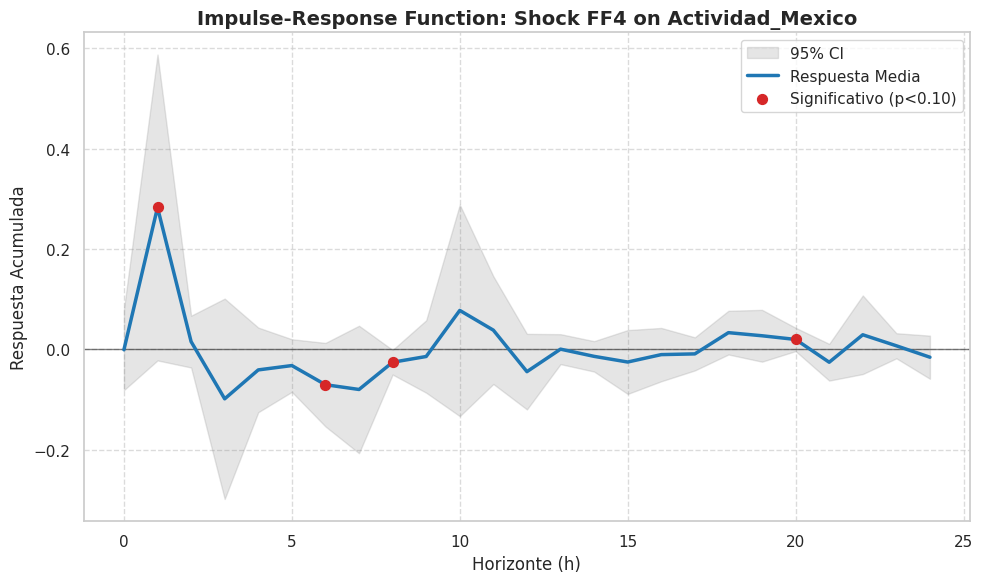


📋 TABLA DE RESULTADOS (DETALLE - IRF Original):
 h    beta  p_value significancia
 0 -0.0009   0.9821              
 1  0.2826   0.0706             *
 2  0.0153   0.5615              
 3 -0.0987   0.3337              
 4 -0.0411   0.3409              
 5 -0.0324   0.2273              
 6 -0.0706   0.0981             *
 7 -0.0801   0.2179              
 8 -0.0258   0.0404            **
 9 -0.0144   0.6968              
10  0.0775   0.4719              
11  0.0381   0.4871              
12 -0.0446   0.2477              
13  0.0003   0.9855              
14 -0.0141   0.3633              
15 -0.0254   0.4353              
16 -0.0106   0.6963              
17 -0.0092   0.5871              
18  0.0332   0.1371              
19  0.0270   0.3076              
20  0.0196   0.1000             *
21 -0.0258   0.1687              
22  0.0289   0.4698              
23  0.0070   0.5848              
24 -0.0158   0.4722              


In [25]:
### EJECUTAR LA FUNCION CON UN EJEMPLO ###
res_mexico = estimar_lp(df_transformado,
                           pais='Mexico',
                           variable_respuesta='d_log_Actividad_MEX',
                           shock='FF4',
                           controles=['d_log_Actividad_MEX_lag1',
                                      'd_log_Actividad_MEX_lag2',
                                      'd_EMBI_MEX_lag1',
                                      'd_EMBI_MEX_lag2',
                                      'd_log_TCR_MEX_lag1',
                                      'd_log_TCR_MEX_lag2',
                                      'd_log_INDPRO_lag1',
                                      'd_log_INDPRO_lag2',
                                      'VIX_lag1',
                                      'VIX_lag2'],
                           h_max=24) # Cantidad de meses a proyectar

display(res_mexico)

plot_irf(res_mexico, "Impulse-Response Function: Shock FF4 on Actividad_Mexico")

Smoothing (suavizado para evitar el efecto serrucho)


� Buscando resultados de LP en memoria...
   ✅ Detectado 'res_argentina' (Argentina). Generando gráfico...


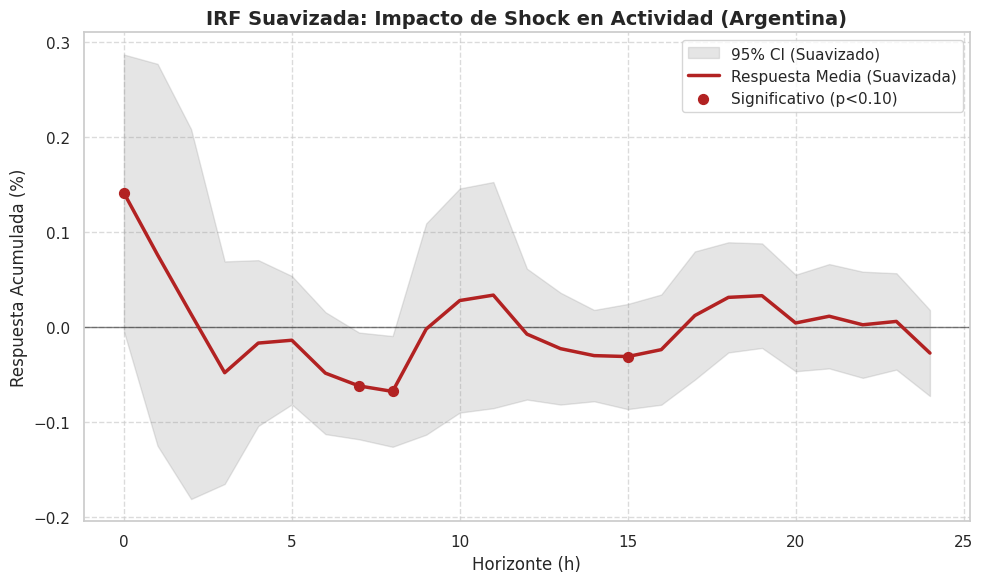


📋 TABLA DE RESULTADOS (DETALLE):
 h    beta  beta_smooth  p_value significancia
 0  0.1415       0.1415   0.0586             *
 1  0.1937       0.0763   0.1974              
 2 -0.1062       0.0138   0.2061              
 3 -0.0461      -0.0479   0.4772              
 4  0.0085      -0.0167   0.7846              
 5 -0.0125      -0.0137   0.7422              
 6 -0.0371      -0.0484   0.2843              
 7 -0.0956      -0.0618   0.0003           ***
 8 -0.0529      -0.0676   0.0410            **
 9 -0.0545      -0.0019   0.1509              
10  0.1015       0.0281   0.3431              
11  0.0373       0.0338   0.3027              
12 -0.0374      -0.0073   0.3448              
13 -0.0217      -0.0226   0.4694              
14 -0.0086      -0.0299   0.6780              
15 -0.0594      -0.0309   0.0102            **
16 -0.0247      -0.0236   0.5481              
17  0.0133       0.0123   0.5942              
18  0.0484       0.0315   0.1975              
19  0.0327       0.0332   

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de Estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def suavizar_y_graficar_irf(df_resultados, titulo="Impulse Response Function (Smoothed)"):
    """
    Aplica suavizado (Rolling Mean) a la IRF y la grafica resaltando significancia.

    Parametros:
    - df_resultados: DataFrame output de 'estimar_lp' (debe tener 'h', 'beta', 'ci_lower', 'ci_upper', 'p_value').
    """
    if df_resultados is None or df_resultados.empty:
        print("❌ Error: DataFrame de resultados vacío.")
        return

    df = df_resultados.copy()

    # -------------------------------------------------------
    # 1. SUAVIZADO (Rolling Mean Centrada)
    # -------------------------------------------------------
    # Ventana de 3 periodos centrada
    df['beta_smooth'] = df['beta'].rolling(window=3, center=True).mean()
    df['lower_smooth'] = df['ci_lower'].rolling(window=3, center=True).mean()
    df['upper_smooth'] = df['ci_upper'].rolling(window=3, center=True).mean()

    # Rellenar extremos (h=0 y h=max) con valores originales para evitar NaNs
    # Usamos combine_first o fillna con los originales
    df['beta_smooth'] = df['beta_smooth'].fillna(df['beta'])
    df['lower_smooth'] = df['lower_smooth'].fillna(df['ci_lower'])
    df['upper_smooth'] = df['upper_smooth'].fillna(df['ci_upper'])

    # -------------------------------------------------------
    # 2. GRÁFICO
    # -------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # Eje 0
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    # Intervalo de Confianza Suavizado
    ax.fill_between(df['h'], df['lower_smooth'], df['upper_smooth'], color='gray', alpha=0.2, label='95% CI (Suavizado)')

    # Línea Beta Suavizada
    ax.plot(df['h'], df['beta_smooth'], color='#b22222', linewidth=2.5, label='Respuesta Media (Suavizada)') # Firebrick color

    # -------------------------------------------------------
    # 3. PUNTOS DE SIGNIFICANCIA
    # Filtrar puntos donde p_value < 0.10
    if 'p_value' in df.columns:
        significativos = df[df['p_value'] < 0.10]

        if not significativos.empty:
            ax.scatter(significativos['h'], significativos['beta_smooth'],
                       color='#b22222', s=50, zorder=5, marker='o', label='Significativo (p<0.10)')
    else:
        print("⚠️ ADVERTENCIA: No se encontró la columna 'p_value'.")
        print("   👉 Posible Causa: Estás usando una versión antigua de 'estimar_lp'.")
        print("   👉 Solución: Vuelve a ejecutar la celda que define la función 'estimar_lp' y luego re-estima.")

    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.set_xlabel('Horizonte (h)', fontsize=12)
    ax.set_ylabel('Respuesta Acumulada (%)', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # -------------------------------------------------------
    # 4. TABLA RESUMEN
    # -------------------------------------------------------
    # 4. TABLA RESUMEN
    print("\n📋 TABLA DE RESULTADOS (DETALLE):")

    # Columnas base que siempre deberían existir
    cols_mostrar = ['h', 'beta', 'beta_smooth']

    # Agregar p_value si existe
    if 'p_value' in df.columns:
        cols_mostrar.append('p_value')

    # Calcular o agregar significancia si es posible
    if 'p_value' in df.columns:
        if 'significancia' not in df.columns:
             df['significancia'] = df['p_value'].apply(lambda x: '***' if x<0.01 else ('**' if x<0.05 else ('*' if x<0.1 else '')))
        cols_mostrar.append('significancia')

    print(df[cols_mostrar].to_string(index=False, float_format='%.4f'))

# -----------------------------------------------------------
# EJECUCIÓN AUTOMÁTICA (Si res_chile existe en memoria)
# -----------------------------------------------------------
if __name__ == "__main__":
    # 1. Lista de posibles variables de resultados en memoria
    # El usuario pidió que reconozca que "va cambiando el país".
    # Asumimos que la variable se llamará: res_chile, res_argentina, res_brasil, res_mexico

    posibles_resultados = {
        'res_chile': 'Chile',
        'res_argentina': 'Argentina',
        'res_brasil': 'Brasil',
        'res_mexico': 'Mexico',
        'res_lp': 'País Genérico' # Fallback
    }

    encontrado = False

    print("\n� Buscando resultados de LP en memoria...")

    # 2. Iterar y graficar lo que se encuentre
    for var_name, pais_nombre in posibles_resultados.items():
        if var_name in globals():
            print(f"   ✅ Detectado '{var_name}' ({pais_nombre}). Generando gráfico...")

            # Obtener dataframe
            df_res = globals()[var_name]

            # Generar título dinámico
            titulo_grafico = f"IRF Suavizada: Impacto de Shock en Actividad ({pais_nombre})"

            # Ejecutar función
            suavizar_y_graficar_irf(df_res, titulo=titulo_grafico)
            encontrado = True

    if not encontrado:
        print("⚠️ No se encontró ningún resultado ('res_chile', 'res_argentina', etc.) en memoria.")
        print("   👉 Ejecuta 'local_projection_function.py' con el país deseado antes de correr este script.")


## Impacto sobre el EMBI

🚀 Estimando LP para Mexico - Variable: d_EMBI_MEX (h_max=24)


,h,beta,se,t_stat,p_value,significancia,es_significativo,ci_lower,ci_upper,obs,r2
0,0,-3.6033,1.9830,-1.8171,0.0706,*,False,-7.4900,0.2834,211,0.4963
1,1,0.0552,1.7328,0.0318,0.9746,,False,-3.3410,3.4514,210,0.5867
2,2,0.2349,0.9797,0.2398,0.8108,,False,-1.6853,2.1551,209,0.5587
3,3,0.6003,0.8172,0.7346,0.4634,,False,-1.0014,2.2020,208,0.5161
4,4,0.1128,0.6420,0.1756,0.8608,,False,-1.1456,1.3711,207,0.5172
5,5,1.0918,0.5280,2.0678,0.0399,**,True,0.0569,2.1267,206,0.5669
6,6,1.4088,0.9175,1.5355,0.1262,,False,-0.3895,3.2071,205,0.5496
7,7,1.9272,1.5237,1.2648,0.2074,,False,-1.0593,4.9136,204,0.5504
8,8,1.1888,0.8621,1.3790,0.1694,,False,-0.5008,2.8785,203,0.5213
9,9,-0.3564,0.9117,-0.3909,0.6963,,False,-2.1432,1.4304,202,0.5740


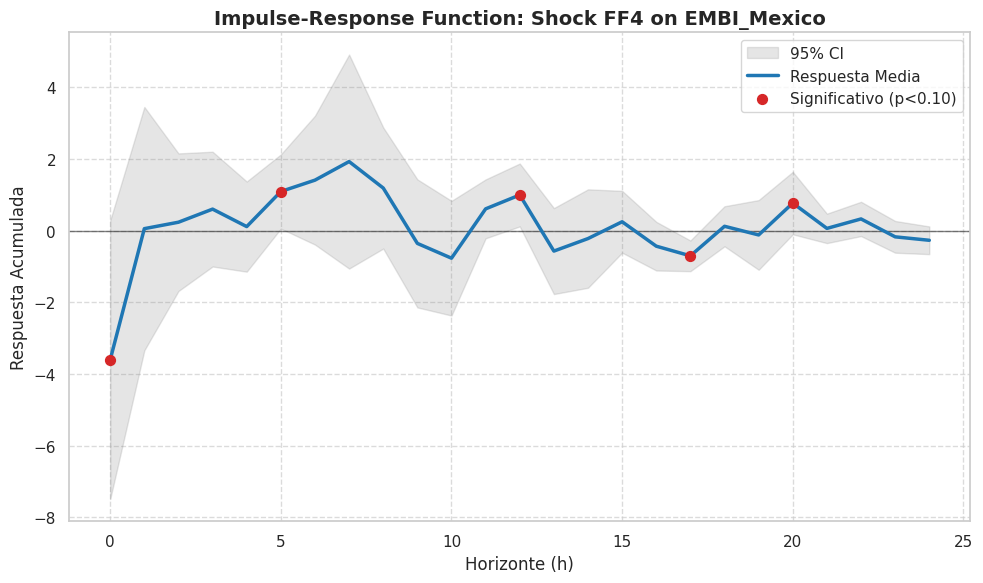


📋 TABLA DE RESULTADOS (DETALLE - IRF Original):
 h    beta  p_value significancia
 0 -3.6033   0.0706             *
 1  0.0552   0.9746              
 2  0.2349   0.8108              
 3  0.6003   0.4634              
 4  0.1128   0.8608              
 5  1.0918   0.0399            **
 6  1.4088   0.1262              
 7  1.9272   0.2074              
 8  1.1888   0.1694              
 9 -0.3564   0.6963              
10 -0.7692   0.3473              
11  0.6075   0.1491              
12  0.9948   0.0274            **
13 -0.5709   0.3521              
14 -0.2213   0.7525              
15  0.2476   0.5743              
16 -0.4337   0.2121              
17 -0.7036   0.0015           ***
18  0.1213   0.6712              
19 -0.1204   0.8086              
20  0.7688   0.0855             *
21  0.0623   0.7666              
22  0.3263   0.1830              
23 -0.1733   0.4441              
24 -0.2694   0.1741              

📈 IRF SUAVIZADA EMBI (Con significancia):


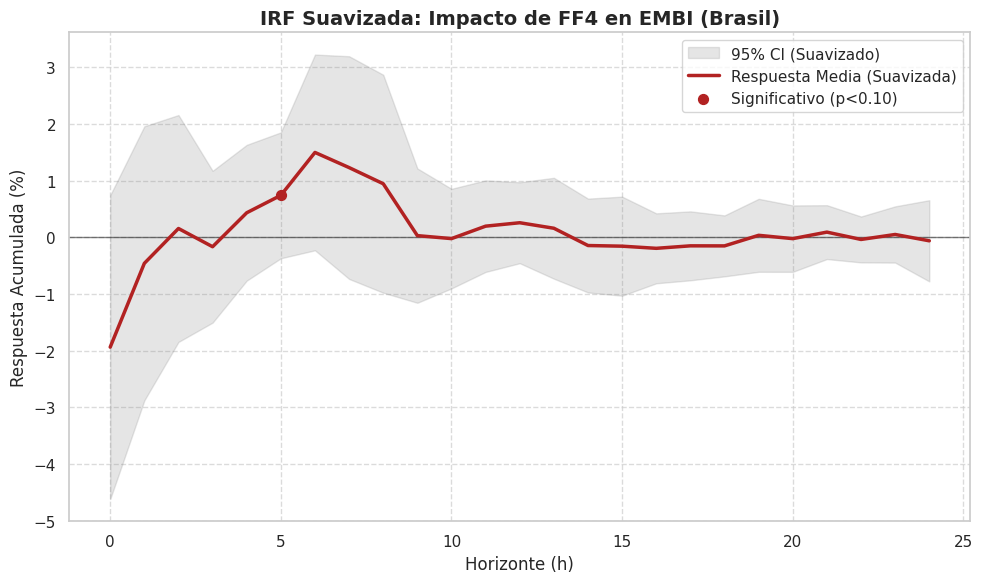


📋 TABLA DE RESULTADOS (DETALLE):
 h    beta  beta_smooth  p_value significancia
 0 -1.9394      -1.9394   0.1577              
 1  1.1190      -0.4608   0.5083              
 2 -0.5620       0.1545   0.3851              
 3 -0.0936      -0.1673   0.8981              
 4  0.1538       0.4323   0.8199              
 5  1.2367       0.7399   0.0044           ***
 6  0.8292       1.4970   0.1662              
 7  2.4252       1.2295   0.1354              
 8  0.4340       0.9444   0.5852              
 9 -0.0259       0.0287   0.9612              
10 -0.3219      -0.0240   0.5109              
11  0.2759       0.1958   0.3960              
12  0.6335       0.2562   0.1365              
13 -0.1408       0.1589   0.6842              
14 -0.0161      -0.1462   0.9783              
15 -0.2816      -0.1575   0.3923              
16 -0.1749      -0.1955   0.6748              
17 -0.1299      -0.1516   0.5175              
18 -0.1499      -0.1525   0.6344              
19 -0.1777       0.0342   

In [32]:
### EJECUTAR LA FUNCION CON UN EJEMPLO ###
res_embi_mexico = estimar_lp(df_transformado,
                           pais='Mexico',
                           variable_respuesta='d_EMBI_MEX',
                           shock='FF4',
                           controles=['d_log_Actividad_MEX_lag1',
                                      'd_log_Actividad_MEX_lag2',
                                      'd_EMBI_MEX_lag1',
                                      'd_EMBI_MEX_lag2',
                                      'd_log_TCR_MEX_lag1',
                                      'd_log_TCR_MEX_lag2'],
                           h_max=24) # Cantidad de meses a proyectar

display(res_embi_mexico)

plot_irf(res_embi_mexico, "Impulse-Response Function: Shock FF4 on EMBI_Mexico")

print("\n📈 IRF SUAVIZADA EMBI (Con significancia):")
suavizar_y_graficar_irf(res_embi_brasil, titulo="IRF Suavizada: Impacto de FF4 en EMBI (Brasil)")

## Impacto sobre TCR

🚀 Estimando LP para Mexico - Variable: d_log_TCR_MEX (h_max=24)


,h,beta,se,t_stat,p_value,significancia,es_significativo,ci_lower,ci_upper,obs,r2
0,0,0.1947,0.1376,1.4150,0.1586,,False,-0.0750,0.4643,211,0.4986
1,1,-0.0180,0.1217,-0.1480,0.8824,,False,-0.2565,0.2205,210,0.5872
2,2,0.0499,0.0652,0.7659,0.4446,,False,-0.0778,0.1776,209,0.5548
3,3,-0.0162,0.0569,-0.2843,0.7764,,False,-0.1277,0.0953,208,0.5096
4,4,0.0021,0.0373,0.0564,0.9550,,False,-0.0710,0.0752,207,0.5426
5,5,0.0283,0.0540,0.5236,0.6011,,False,-0.0775,0.1340,206,0.5876
6,6,-0.0353,0.0716,-0.4923,0.6230,,False,-0.1757,0.1051,205,0.5314
7,7,-0.1260,0.1213,-1.0393,0.2999,,False,-0.3637,0.1116,204,0.5056
8,8,-0.0725,0.0671,-1.0794,0.2817,,False,-0.2041,0.0591,203,0.5233
9,9,0.0139,0.0641,0.2173,0.8282,,False,-0.1117,0.1396,202,0.5728


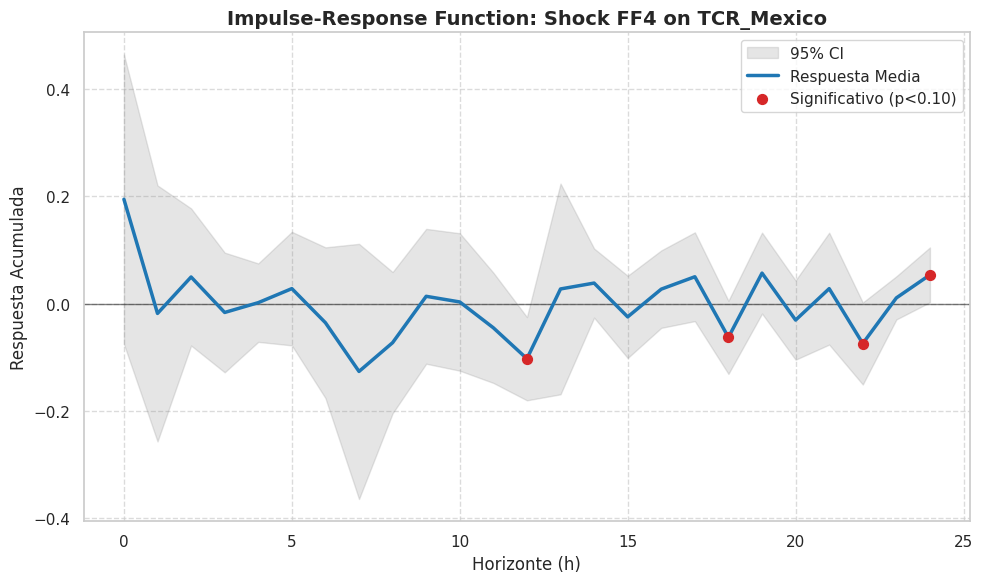


📋 TABLA DE RESULTADOS (DETALLE - IRF Original):
 h    beta  p_value significancia
 0  0.1947   0.1586              
 1 -0.0180   0.8824              
 2  0.0499   0.4446              
 3 -0.0162   0.7764              
 4  0.0021   0.9550              
 5  0.0283   0.6011              
 6 -0.0353   0.6230              
 7 -0.1260   0.2999              
 8 -0.0725   0.2817              
 9  0.0139   0.8282              
10  0.0034   0.9588              
11 -0.0447   0.3943              
12 -0.1023   0.0104            **
13  0.0276   0.7831              
14  0.0386   0.2414              
15 -0.0244   0.5330              
16  0.0273   0.4595              
17  0.0504   0.2340              
18 -0.0625   0.0735             *
19  0.0572   0.1390              
20 -0.0303   0.4222              
21  0.0282   0.5967              
22 -0.0740   0.0590             *
23  0.0110   0.5938              
24  0.0539   0.0401            **

📈 IRF SUAVIZADA TCR (Con significancia):


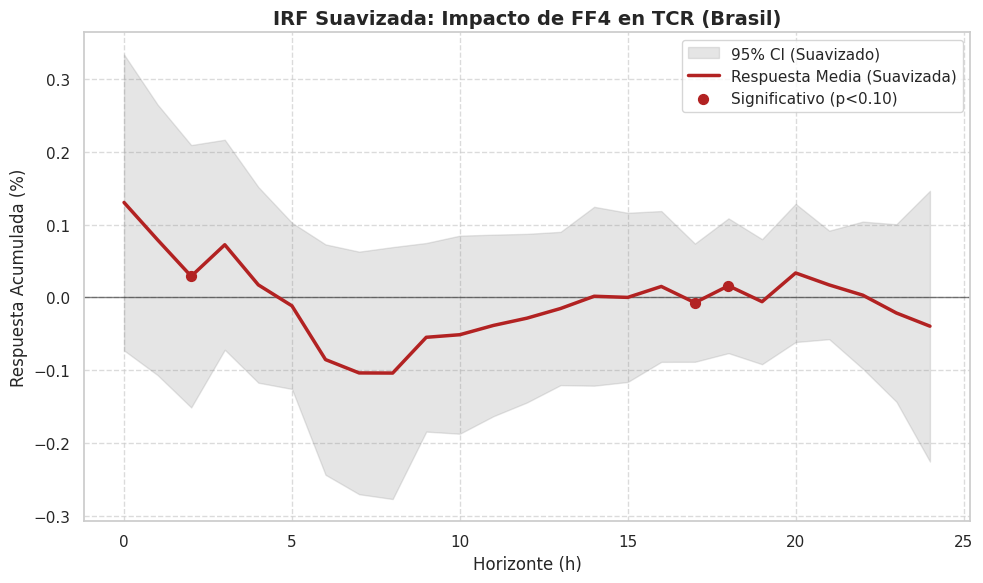


📋 TABLA DE RESULTADOS (DETALLE):
 h    beta  beta_smooth  p_value significancia
 0  0.1303       0.1303   0.2106              
 1 -0.0762       0.0789   0.5219              
 2  0.1826       0.0289   0.0036           ***
 3 -0.0197       0.0722   0.8364              
 4  0.0536       0.0170   0.4016              
 5  0.0171      -0.0118   0.7154              
 6 -0.1061      -0.0857   0.1000              
 7 -0.1680      -0.1040   0.2021              
 8 -0.0379      -0.1042   0.5260              
 9 -0.1066      -0.0550   0.1515              
10 -0.0206      -0.0515   0.7509              
11 -0.0272      -0.0387   0.6960              
12 -0.0683      -0.0287   0.2294              
13  0.0094      -0.0154   0.8535              
14  0.0126       0.0014   0.8143              
15 -0.0178      -0.0002   0.8313              
16  0.0047       0.0149   0.9079              
17  0.0577      -0.0075   0.0932             *
18 -0.0848       0.0158   0.0872             *
19  0.0746      -0.0061   

In [42]:
### EJECUTAR LA FUNCION CON UN EJEMPLO ###
res_tcr_mexico = estimar_lp(df_transformado,
                           pais='Mexico',
                           variable_respuesta='d_log_TCR_MEX',
                           shock='FF4',
                           controles=['d_log_Actividad_MEX_lag1',
                                      'd_log_Actividad_MEX_lag2',
                                      'd_EMBI_MEX_lag1',
                                      'd_EMBI_MEX_lag2',
                                      'd_log_TCR_MEX_lag1',
                                      'd_log_TCR_MEX_lag2',
                                      'd_log_INDPRO_lag1',
                                      'd_log_INDPRO_lag2',
                                      'VIX_lag1',
                                      'VIX_lag2'],
                           h_max=24) # Cantidad de meses a proyectar

display(res_tcr_mexico)

plot_irf(res_tcr_mexico, "Impulse-Response Function: Shock FF4 on TCR_Mexico")

print("\n📈 IRF SUAVIZADA TCR (Con significancia):")
suavizar_y_graficar_irf(res_tcr_brasil, titulo="IRF Suavizada: Impacto de FF4 en TCR (Brasil)")

# Matriz


In [15]:
import pandas as pd

# 1. Definir listas de países y variables de respuesta
PAISES = ['ARG', 'BRA', 'CHL', 'MEX']
VARIABLES_RESPUESTA = ['Actividad', 'EMBI', 'TCR']

def get_controls_for_irf(df_transformed, country_code, response_type):
    """
    Construye dinámicamente la variable de respuesta y la lista de variables de control
    para la función de Proyecciones Locales (IRF).

    Args:
        df_transformed (pd.DataFrame): DataFrame con todas las variables transformadas y rezagadas.
        country_code (str): Código de país (e.g., 'ARG', 'BRA').
        response_type (str): Tipo de variable de respuesta (e.g., 'Actividad', 'EMBI', 'TCR').

    Returns:
        tuple: (response_var_name, control_vars_list) si todo es válido, de lo contrario (None, None).
    """
    # 4a. Construir el nombre de la variable de respuesta
    response_var_name = None
    if response_type == 'EMBI':
        response_var_name = f"d_{response_type}_{country_code}"
    elif response_type in ['Actividad', 'TCR']:
        response_var_name = f"d_log_{response_type}_{country_code}"
    else:
        print(f"⚠️ Tipo de respuesta desconocido: {response_type}")
        return None, None

    # 4c. Verificar que la variable de respuesta exista
    if response_var_name not in df_transformed.columns:
        print(f"❌ Variable de respuesta '{response_var_name}' no encontrada en df_transformed.")
        return None, None

    # 4b. Construir la lista base de variables de control
    # Incluye rezagos de la propia variable de respuesta
    base_controls_names = [
        f"{response_var_name}_lag1",
        f"{response_var_name}_lag2"
    ]

    # Incluye otras variables del país (Actividad, EMBI, TCR)
    all_country_vars = {
        'Actividad': f"d_log_Actividad_{country_code}",
        'EMBI': f"d_EMBI_{country_code}",
        'TCR': f"d_log_TCR_{country_code}"
    }

    for other_type, other_var_name in all_country_vars.items():
        # Excluir la propia variable de respuesta ya que sus rezagos ya están incluidos
        if other_type != response_type:
            base_controls_names.extend([
                f"{other_var_name}_lag1",
                f"{other_var_name}_lag2"
            ])

    # Incluye variables globales (condicionalmente)
    global_vars_to_consider = {
        'INDPRO': 'd_log_INDPRO',
        'VIX': 'VIX'
    }

    if response_type != 'EMBI': # Excluir INDPRO y VIX para EMBI
        for global_alias, global_var_name in global_vars_to_consider.items():
            base_controls_names.extend([
                f"{global_var_name}_lag1",
                f"{global_var_name}_lag2"
            ])

    # 4c. Filtrar las variables de control para asegurar que existan en df_transformed
    control_vars_list = []
    for control_var in base_controls_names:
        if control_var in df_transformed.columns:
            control_vars_list.append(control_var)
        else:
            print(f"⚠️ Control '{control_var}' no encontrado en df_transformed y será excluido.")

    if not control_vars_list:
        print(f"❌ No se pudieron construir variables de control válidas para {country_code}-{response_type}.")
        return None, None

    print(f"✅ Para {country_code}-{response_type}: Response='{response_var_name}', Controls={len(control_vars_list)} variables.")
    return response_var_name, control_vars_list

print("Listas PAISES y VARIABLES_RESPUESTA definidas. Función get_controls_for_irf creada.")

Listas PAISES y VARIABLES_RESPUESTA definidas. Función get_controls_for_irf creada.


In [16]:
irf_results = {}

print("🚀 Generando todas las Funciones de Impulso-Respuesta (IRFs)...\n")

for pais_code in PAISES:
    for var_tipo in VARIABLES_RESPUESTA:
        print(f"--- Procesando {pais_code} - {var_tipo} ---")
        response_var, controls = get_controls_for_irf(df_transformado, pais_code, var_tipo)

        if response_var and controls:
            try:
                # Asegurarse de que el shock 'FF4' exista en df_transformado
                if 'FF4' not in df_transformado.columns:
                    print("❌ Error: La variable 'FF4' (shock) no se encuentra en df_transformado.")
                    continue

                res = estimar_lp(df_transformado,
                                 pais=pais_code,
                                 variable_respuesta=response_var,
                                 shock='FF4',
                                 controles=controls,
                                 h_max=24)
                irf_results[f'{pais_code}_{var_tipo}'] = res
                print(f"   ✅ IRF para {pais_code}-{var_tipo} estimada y guardada.\n")
            except Exception as e:
                print(f"   ❌ Error al estimar LP para {pais_code}-{var_tipo}: {e}\n")
        else:
            print(f"   ⚠️ No se pudo generar IRF para {pais_code}-{var_tipo} debido a variables faltantes.\n")

print("🏁 Todas las IRFs se han generado y guardado en 'irf_results'.")
print(f"Total de IRFs generadas: {len(irf_results)}")

🚀 Generando todas las Funciones de Impulso-Respuesta (IRFs)...

--- Procesando ARG - Actividad ---
✅ Para ARG-Actividad: Response='d_log_Actividad_ARG', Controls=10 variables.
🚀 Estimando LP para ARG - Variable: d_log_Actividad_ARG (h_max=24)
   ✅ IRF para ARG-Actividad estimada y guardada.

--- Procesando ARG - EMBI ---
✅ Para ARG-EMBI: Response='d_EMBI_ARG', Controls=6 variables.
🚀 Estimando LP para ARG - Variable: d_EMBI_ARG (h_max=24)
   ✅ IRF para ARG-EMBI estimada y guardada.

--- Procesando ARG - TCR ---
✅ Para ARG-TCR: Response='d_log_TCR_ARG', Controls=10 variables.
🚀 Estimando LP para ARG - Variable: d_log_TCR_ARG (h_max=24)
   ✅ IRF para ARG-TCR estimada y guardada.

--- Procesando BRA - Actividad ---
✅ Para BRA-Actividad: Response='d_log_Actividad_BRA', Controls=10 variables.
🚀 Estimando LP para BRA - Variable: d_log_Actividad_BRA (h_max=24)
   ✅ IRF para BRA-Actividad estimada y guardada.

--- Procesando BRA - EMBI ---
✅ Para BRA-EMBI: Response='d_EMBI_BRA', Controls=6 var

📈 Generando gráficos de las Funciones de Impulso-Respuesta Suavizadas...


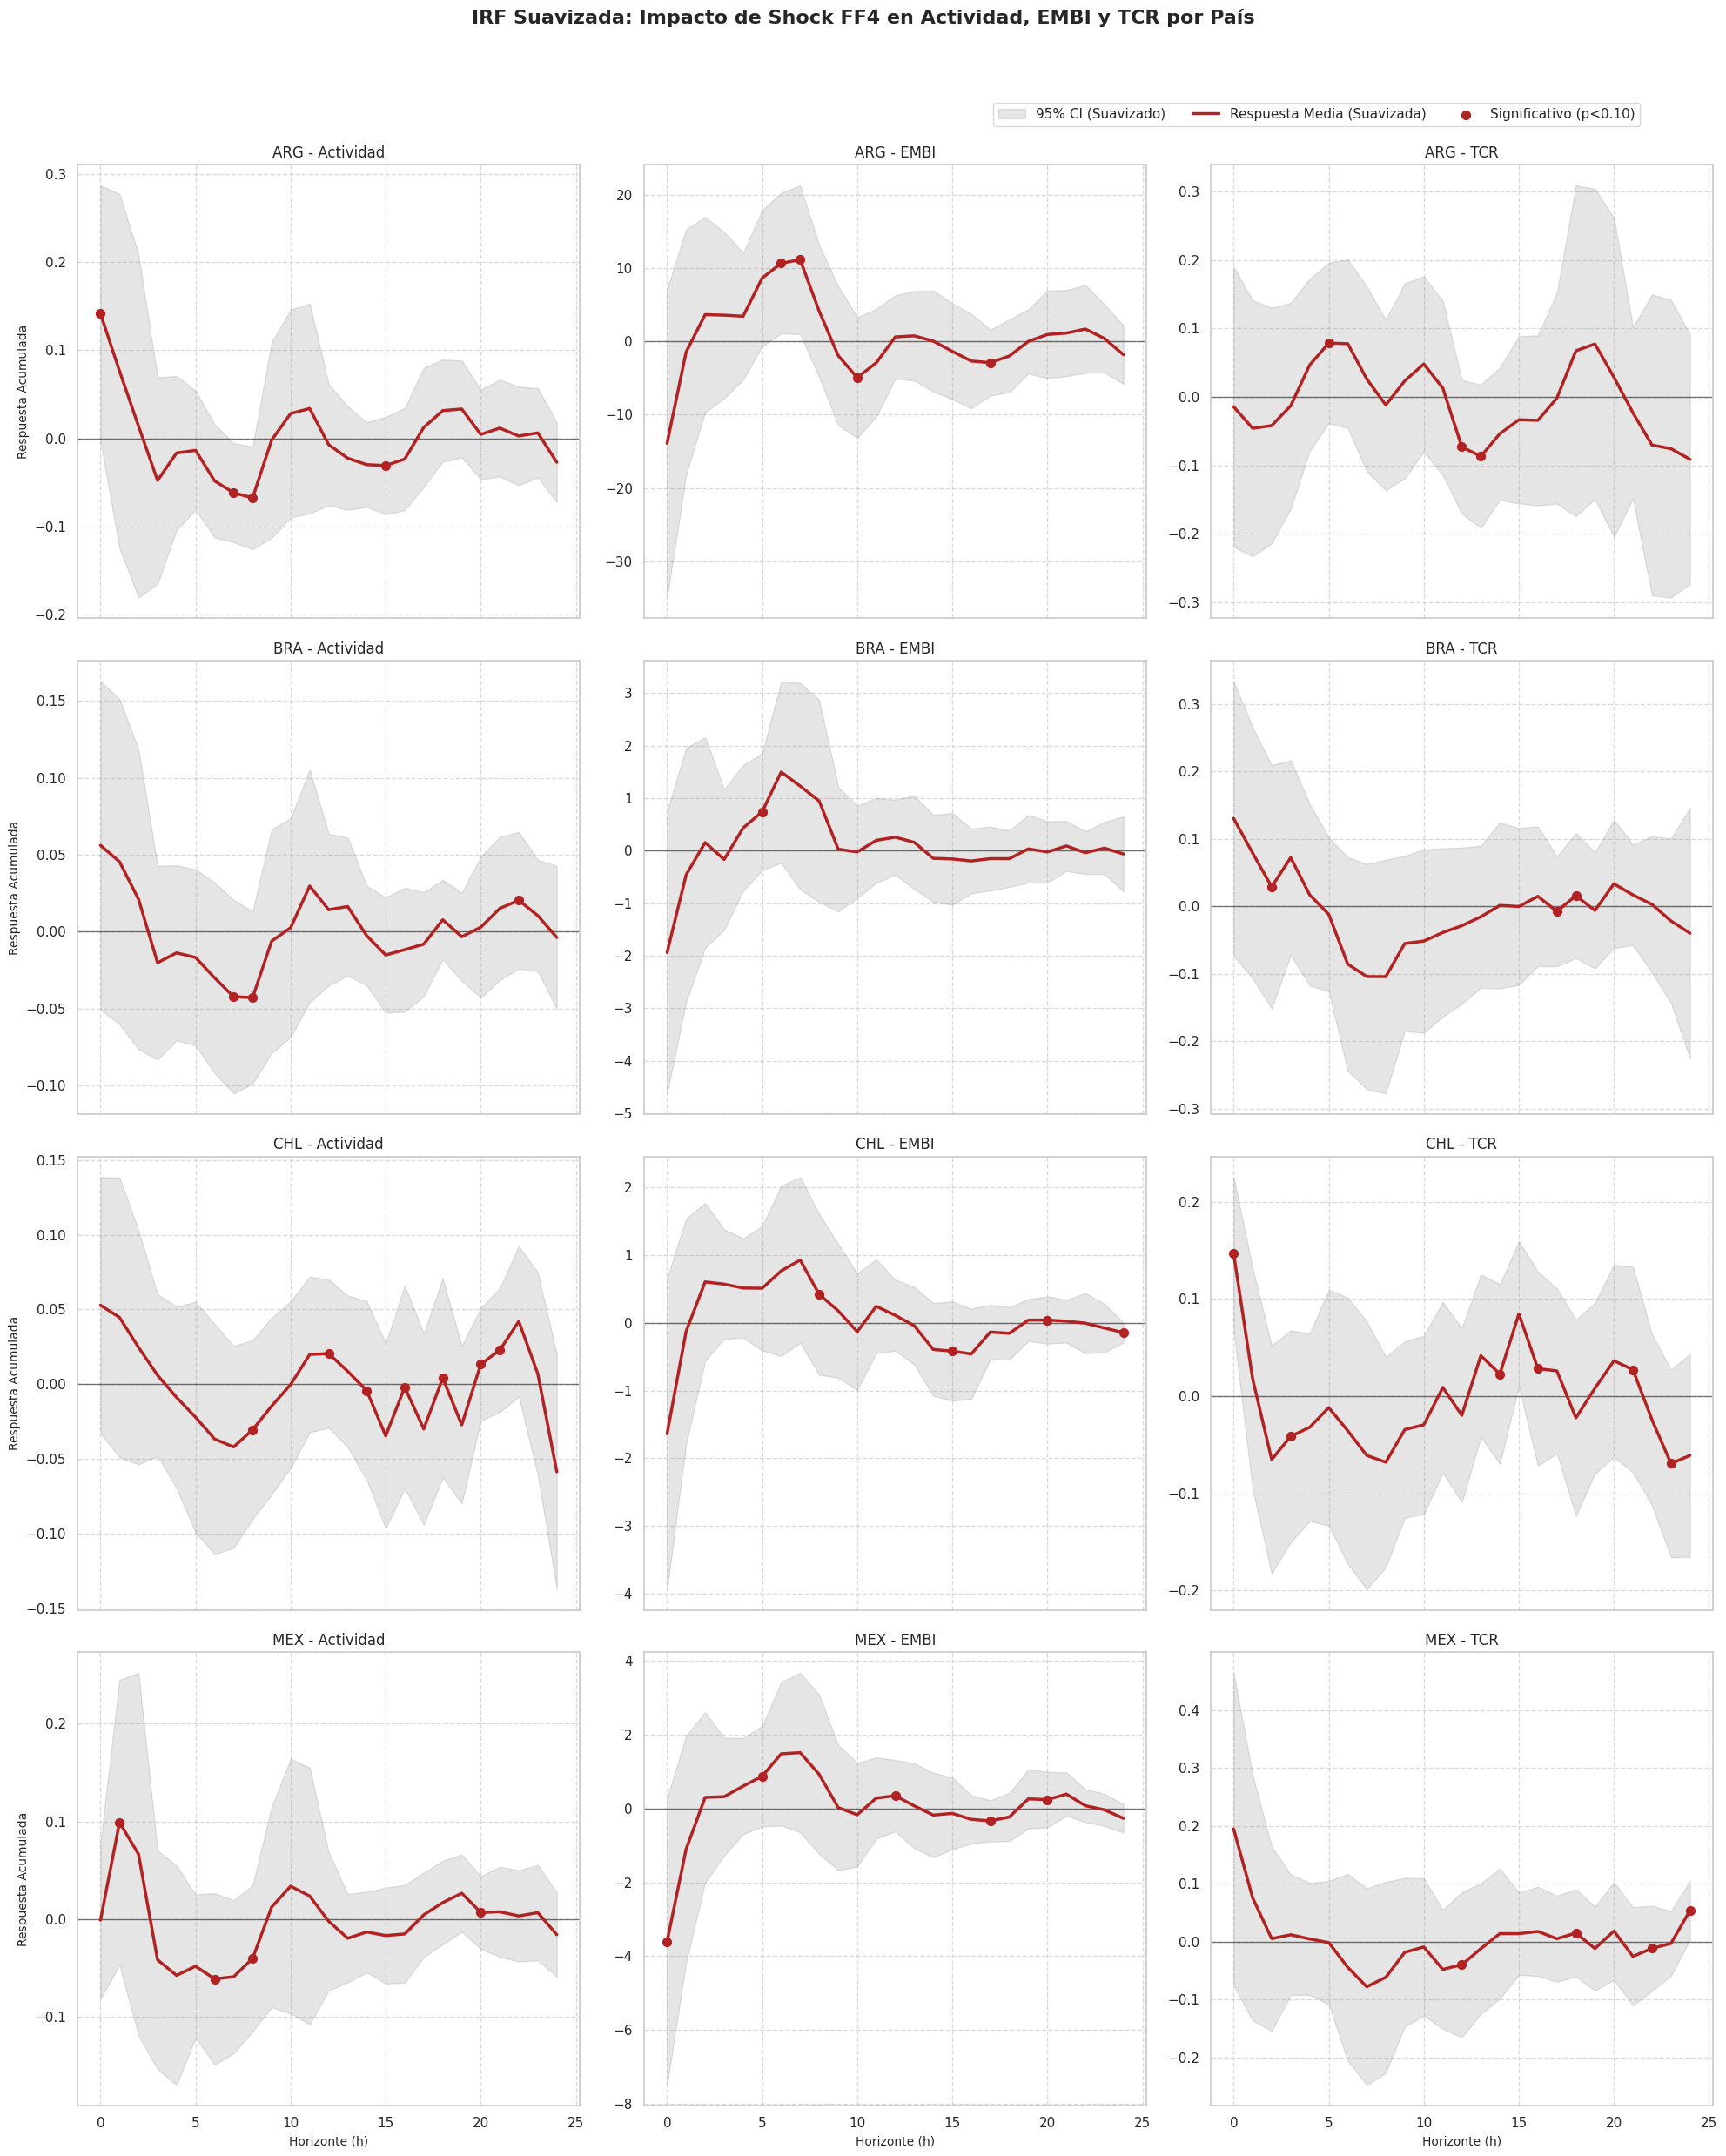

🏁 Todos los gráficos de IRF se han generado.


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Establecer el estilo de seaborn para una mejor visualización
sns.set_theme(style="whitegrid")

# Crear la figura y el grid de subplots
fig, axes = plt.subplots(nrows=len(PAISES), ncols=len(VARIABLES_RESPUESTA), figsize=(20, 25), sharex=True)

print("📈 Generando gráficos de las Funciones de Impulso-Respuesta Suavizadas...")

# Iterar sobre los resultados y graficar en el grid
for i, pais_code in enumerate(PAISES):
    for j, var_tipo in enumerate(VARIABLES_RESPUESTA):
        key = f'{pais_code}_{var_tipo}'
        if key in irf_results:
            df_res = irf_results[key].copy()

            # Aplicar suavizado (Rolling Mean Centrada)
            df_res['beta_smooth'] = df_res['beta'].rolling(window=3, center=True).mean()
            df_res['lower_smooth'] = df_res['ci_lower'].rolling(window=3, center=True).mean()
            df_res['upper_smooth'] = df_res['ci_upper'].rolling(window=3, center=True).mean()
            df_res['beta_smooth'] = df_res['beta_smooth'].fillna(df_res['beta'])
            df_res['lower_smooth'] = df_res['lower_smooth'].fillna(df_res['ci_lower'])
            df_res['upper_smooth'] = df_res['upper_smooth'].fillna(df_res['ci_upper'])

            # Obtener el eje actual
            ax = axes[i, j]

            # Eje 0
            ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

            # Intervalo de Confianza Suavizado
            ax.fill_between(df_res['h'], df_res['lower_smooth'], df_res['upper_smooth'],
                            color='gray', alpha=0.2, label='95% CI (Suavizado)')

            # Línea Beta Suavizada
            ax.plot(df_res['h'], df_res['beta_smooth'], color='#b22222', linewidth=2.5, label='Respuesta Media (Suavizada)')

            # Puntos de Significancia
            if 'p_value' in df_res.columns:
                significativos = df_res[df_res['p_value'] < 0.10]
                if not significativos.empty:
                    ax.scatter(significativos['h'], significativos['beta_smooth'],
                               color='#b22222', s=50, zorder=5, marker='o', label='Significativo (p<0.10)')

            # Títulos y etiquetas
            ax.set_title(f'{pais_code} - {var_tipo}', fontsize=12)
            if i == len(PAISES) - 1: # Solo en la fila inferior
                ax.set_xlabel('Horizonte (h)', fontsize=10)
            if j == 0: # Solo en la primera columna
                ax.set_ylabel('Respuesta Acumulada', fontsize=10)
            ax.legend().set_visible(False) # Ocultar leyenda individual para no saturar
            ax.grid(True, linestyle='--', alpha=0.7)

# Añadir una leyenda global en la parte superior derecha
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98), ncol=3, frameon=True)

plt.suptitle('IRF Suavizada: Impacto de Shock FF4 en Actividad, EMBI y TCR por País',
             fontsize=16, fontweight='bold', y=1.02) # Título general
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajustar diseño para dejar espacio para el título general
plt.show()

print("🏁 Todos los gráficos de IRF se han generado.")

# Test de significancia conjunta (Wald)

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.system import SUR

def realizar_test_conjunto(df, variable_respuesta, shock, controles, h_max=12):
    """
    Realiza un Test de Wald de Significancia Conjunta para la IRF completa.
    H0: beta_0 = beta_1 = ... = beta_h = 0

    Utiliza un sistema SUR (Seemingly Unrelated Regressions) estimado conjuntamente
    para capturar la correlación entre los errores de distintos horizontes.
    """
    print(f"\n🧪 INICIANDO TEST DE WALD CONJUNTO ({variable_respuesta} ~ {shock})")
    print(f"   Horizonte: 0 a {h_max}")

    # 1. PREPARACIÓN DE DATOS (Muestra Común)
    # Para estimar el sistema conjunto, necesitamos que todas las ecuaciones
    # tengan las mismas observaciones (o manejarlas cuidadosamente).
    # Restringiremos la muestra a los datos válidos para el horizonte MÁS LEJANO.

    cols_req = [variable_respuesta, shock] + controles
    df_clean = df.dropna(subset=cols_req).copy()

    # Crear el sistema de ecuaciones para linearmodels
    ecuaciones = {}

    # Identificar índices válidos comunes
    # Debemos asegurar que y_{t+h} existe para todo h.
    # El shift(-h_max) es el más restrictivo.
    idx_start = df_clean.index[0]
    idx_end = df_clean.index[-1 - h_max] # Cortamos los últimos h_max

    # Filtrar el dataframe base para X (variables en t-1 o t)
    # La muestra efectiva de X va hasta T - h_max
    # Sin embargo, linearmodels maneja índices. Lo mejor es construir un DF por ecuación.

    # Vamos a iterar y construir cada ecuación asegurando el MISMO índice
    # Intersection logic:
    valid_indices = df_clean.index
    for h in range(h_max + 1):
        # Indices donde y_{t+h} es válido
        y_leads = df_clean[variable_respuesta].shift(-h)
        valid_h = y_leads.dropna().index
        valid_indices = valid_indices.intersection(valid_h)

    print(f"   Observaciones comunes para el sistema: {len(valid_indices)}")

    if len(valid_indices) < 50:
         print("⚠️ ADVERTENCIA: Pocas observaciones para un sistema conjunto.")

    df_sistema = df_clean.loc[valid_indices].copy()

    # Construir diccionario de ecuaciones
    for h in range(h_max + 1):
        # LHS: y_{t+h} - y_{t-1}
        y_lead = df_clean.loc[valid_indices, variable_respuesta].shift(-h) # Ojo, shift sobre copia o original?
        # Cuidado: df_clean ya tiene todos, pero valid_indices es el subset.
        # Mejor usar el df_clean completo para shiftear y LUEGO recortar.

        y_h = df_clean[variable_respuesta].shift(-h).loc[valid_indices]
        y_prev = df_clean[variable_respuesta].shift(1).loc[valid_indices]
        lhs = y_h - y_prev
        lhs.name = f"eq{h}"

        # RHS
        X = df_clean.loc[valid_indices, [shock] + controles]
        X = sm.add_constant(X)

        ecuaciones[f'h{h}'] = {'dependent': lhs, 'exog': X}

    # 2. ESTIMACIÓN SUR CON HAC
    # Usamos kernel='newey-west' para robustez a heterocedasticidad y autocorrelación
    try:
        # Nota: bandwidth=None deja que lo estime automático (o h+1)
        sistema = SUR(ecuaciones)
        res_sur = sistema.fit(cov_type='kernel', kernel='newey-west') # Robust covariance

    except Exception as e:
        print(f"❌ Error en la estimación SUR: {e}")
        return

    # 3. CONSTRUIR SUPUESTOS DEL TEST DE WALD
    # Queremos probar que el coeficiente del 'shock' es 0 en TODAS las ecuaciones.
    # Los nombres de los parámetros en linearmodels SUR suelen ser: "eq_name_var_name"
    # Ejemplo: "h0_FF4", "h1_FF4", ...

    restricciones = []

    # Verificamos cómo nombró las columnas linearmodels
    params = res_sur.params.index

    for h in range(h_max + 1):
        nombre_param = f"h{h}_{shock}" # Formato estándar: {equation}_{variable}
        if nombre_param in params:
            restricciones.append(f"{nombre_param} = 0")
        else:
            print(f"   ⚠️ No encontré el parámetro {nombre_param} en el modelo.")

    if not restricciones:
         print("❌ No se generaron restricciones válidas.")
         return

    # 4. EJECUTAR TEST DE WALD (Cálculo Matemático Directo)
    # Dada la limitación de la librería instalada, implementamos la fórmula exacta.
    # Wald Chi-Square = beta' * inv(Cov) * beta
    from scipy.stats import chi2

    try:
        # 1. Identificar parámetros de interés
        toda_params = res_sur.params
        toda_cov = res_sur.cov

        # Filtar coeficientes: Buscamos "shock" en el índice
        # Manejo robusto para MultiIndex (Equation, Variable) o strings planos
        shock_params = []
        is_multiindex = isinstance(toda_params.index, pd.MultiIndex)

        if is_multiindex:
            # Opción A: MultiIndex
            for idx in toda_params.index:
                if shock in idx:
                    # Verificar coincidencia exacta en el nivel de variable (variable suele ser nivel 1)
                     if idx[1] == shock:
                        shock_params.append(idx)
        else:
            # Opción B: Flat Index
            # Buscamos sufijo o coincidencia exacta
            shock_params = [p for p in toda_params.index if str(p).endswith(f"_{shock}")]
            if not shock_params:
                shock_params = [p for p in toda_params.index if shock in str(p)]

        if len(shock_params) == 0:
            print(f"❌ ERROR: No se encontraron coeficientes para la variable '{shock}'.")
            print(f"   Indices disponibles: {list(toda_params.index)[:10]}...")
            return None

        # Ordenar parámetros (h0, h1, ...) para reportar grados de libertad consistentes
        try:
             if is_multiindex:
                 shock_params.sort(key=lambda x: int(x[0].replace('h','')))
             else:
                 shock_params.sort(key=lambda x: int(x.split('_')[0].replace('h','')))
        except:
             pass

        # 2. Extraer sub-vector Beta y sub-matriz Covarianza
        b_vec = toda_params[shock_params]
        V_mat = toda_cov.loc[shock_params, shock_params]

        # 3. Calcular Estadístico Wald
        try:
            V_inv = np.linalg.inv(V_mat.values)
            wald_stat = b_vec.values.T @ V_inv @ b_vec.values
        except np.linalg.LinAlgError:
            print("❌ ERROR: La matriz de covarianza es singular (no invertible).")
            print("   Posible colinealidad perfecta entre los horizontes o datos insuficientes.")
            return None

        # 4. Inferencia
        df_wald = len(b_vec)
        p_val = 1 - chi2.cdf(wald_stat, df=df_wald)

        # --- REPORTE ---
        print("\n📊 RESULTADOS DEL TEST DE SIGNIFICANCIA CONJUNTA (WALD):")
        print("--------------------------------------------------")
        print(f"Hipótesis Nula: El efecto de {shock} es 0 en todos los horizontes (h=0...{h_max}).")
        print(f"Metodología:      SUR-HAC (Chi-Square Benchmark)")
        print(f"Estadístico Wald: {wald_stat:.4f}")
        print(f"P-Valor:          {p_val:.4f}")
        print(f"Grados de Lib:    {df_wald}")
        print("--------------------------------------------------")

        if p_val < 0.05:
            print("✅ RECHAZAMOS H0: El shock tiene un efecto CONJUNTO SIGNIFICATIVO.")
        else:
            print("❌ NO RECHAZAMOS H0: No hay evidencia de efecto conjunto significativo.")

        # Retornar objeto simple
        class WaldResult:
            def __init__(self, stat, p, df):
                self.stat = stat
                self.pvalue = p
                self.df = df
        return WaldResult(wald_stat, p_val, df_wald)

    except Exception as e:
        print(f"\n❌ ERROR CRÍTICO AL CALCULAR TEST: {e}")
        import traceback
        traceback.print_exc()
        return None

# -----------------------------------------------------------
# EJECUCIÓN DE EJEMPLO
# -----------------------------------------------------------
if __name__ == "__main__":
    if 'df_transformado' in locals():
        print("✅ Datos detectados en memoria.")

        # Test para Chile (Actividad)
        realizar_test_conjunto(globals()['df_transformado'],
                               variable_respuesta='d_log_TCR_MEX',
                               shock='FF4',
                               controles=['d_log_Actividad_MEX_lag1',
                                          'd_log_Actividad_MEX_lag2',
                                          'd_EMBI_MEX_lag1',
                                          'd_EMBI_MEX_lag2',
                                          'd_log_TCR_MEX_lag1',
                                          'd_log_TCR_MEX_lag2',
                                          'd_log_INDPRO_lag1',
                                          'd_log_INDPRO_lag2',
                                          'VIX_lag1',
                                          'VIX_lag2'],
                           h_max=12) # Usamos 12 meses para el test conjunto (más poder)
    else:
        print("⚠️ 'df_transformado' no encontrado. Ejecuta la carga de datos primero.")


✅ Datos detectados en memoria.

🧪 INICIANDO TEST DE WALD CONJUNTO (d_log_TCR_MEX ~ FF4)
   Horizonte: 0 a 12
   Observaciones comunes para el sistema: 200


/usr/local/lib/python3.12/dist-packages/linearmodels/system/model.py:397: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  self._validate_data()



📊 RESULTADOS DEL TEST DE SIGNIFICANCIA CONJUNTA (WALD):
--------------------------------------------------
Hipótesis Nula: El efecto de FF4 es 0 en todos los horizontes (h=0...12).
Metodología:      SUR-HAC (Chi-Square Benchmark)
Estadístico Wald: 84.0982
P-Valor:          0.0000
Grados de Lib:    13
--------------------------------------------------
✅ RECHAZAMOS H0: El shock tiene un efecto CONJUNTO SIGNIFICATIVO.


# Test de sensibilidad de rezagos


⚠️ No se pudieron importar los archivos .py (probablemente por ruta de Colab).
   🔍 Buscando funciones 'estimar_lp' y 'realizar_test_conjunto' en memoria...

🔬 ANÁLISIS DE SENSIBILIDAD DE REZAGOS (Robustez)
   País: Mexico | Respuesta: d_log_TCR_MEX | Shock: FF4
   Lags a evaluar: [2, 4, 6]

--- Estimando Modelo con 2 Lags ---
🚀 Estimando LP para Mexico - Variable: d_log_TCR_MEX (h_max=12)

🧪 INICIANDO TEST DE WALD CONJUNTO (d_log_TCR_MEX ~ FF4)
   Horizonte: 0 a 12
   Observaciones comunes para el sistema: 200


/usr/local/lib/python3.12/dist-packages/linearmodels/system/model.py:397: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  self._validate_data()



📊 RESULTADOS DEL TEST DE SIGNIFICANCIA CONJUNTA (WALD):
--------------------------------------------------
Hipótesis Nula: El efecto de FF4 es 0 en todos los horizontes (h=0...12).
Metodología:      SUR-HAC (Chi-Square Benchmark)
Estadístico Wald: 84.0982
P-Valor:          0.0000
Grados de Lib:    13
--------------------------------------------------
✅ RECHAZAMOS H0: El shock tiene un efecto CONJUNTO SIGNIFICATIVO.

--- Estimando Modelo con 4 Lags ---
🚀 Estimando LP para Mexico - Variable: d_log_TCR_MEX (h_max=12)

🧪 INICIANDO TEST DE WALD CONJUNTO (d_log_TCR_MEX ~ FF4)
   Horizonte: 0 a 12
   Observaciones comunes para el sistema: 196


/usr/local/lib/python3.12/dist-packages/linearmodels/system/model.py:397: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  self._validate_data()



📊 RESULTADOS DEL TEST DE SIGNIFICANCIA CONJUNTA (WALD):
--------------------------------------------------
Hipótesis Nula: El efecto de FF4 es 0 en todos los horizontes (h=0...12).
Metodología:      SUR-HAC (Chi-Square Benchmark)
Estadístico Wald: 78.5616
P-Valor:          0.0000
Grados de Lib:    13
--------------------------------------------------
✅ RECHAZAMOS H0: El shock tiene un efecto CONJUNTO SIGNIFICATIVO.

--- Estimando Modelo con 6 Lags ---
🚀 Estimando LP para Mexico - Variable: d_log_TCR_MEX (h_max=12)

🧪 INICIANDO TEST DE WALD CONJUNTO (d_log_TCR_MEX ~ FF4)
   Horizonte: 0 a 12
   Observaciones comunes para el sistema: 194


/usr/local/lib/python3.12/dist-packages/linearmodels/system/model.py:397: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  self._validate_data()



📊 RESULTADOS DEL TEST DE SIGNIFICANCIA CONJUNTA (WALD):
--------------------------------------------------
Hipótesis Nula: El efecto de FF4 es 0 en todos los horizontes (h=0...12).
Metodología:      SUR-HAC (Chi-Square Benchmark)
Estadístico Wald: 55.7371
P-Valor:          0.0000
Grados de Lib:    13
--------------------------------------------------
✅ RECHAZAMOS H0: El shock tiene un efecto CONJUNTO SIGNIFICATIVO.

📋 TABLA COMPARATIVA DE ROBUSTEZ (Test de Wald):
 Lags  Wald Stat  P-value Significativo
    2    84.0982   0.0000             ✅
    4    78.5616   0.0000             ✅
    6    55.7371   0.0000             ✅


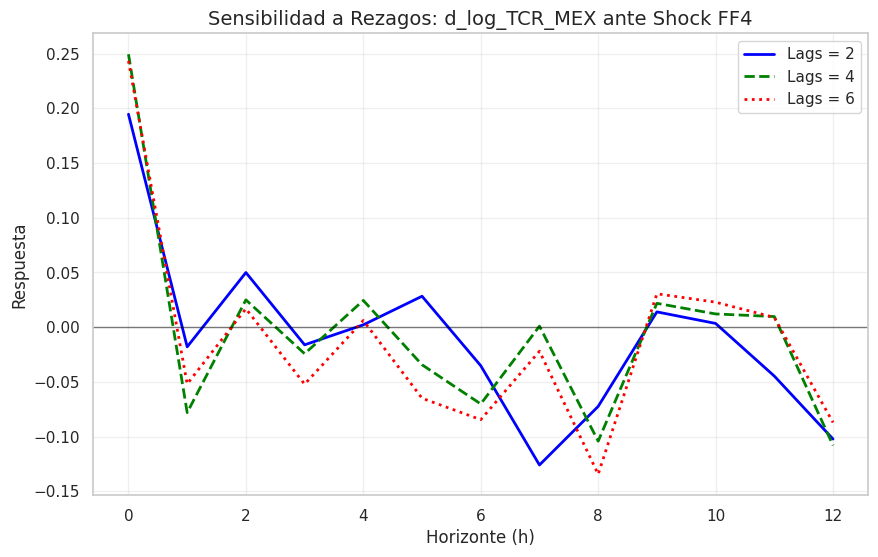

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Intentar importar funciones de otros archivos.
# Si falla (común en Colab), buscamos en el entorno global por si el usuario ya ejecutó esas celdas.
try:
    from local_projection_function import estimar_lp
    from test_de_significancia_conjunta import realizar_test_conjunto
    print("✅ Módulos importados correctamente desde archivos (.py).")
except ImportError:
    print("⚠️ No se pudieron importar los archivos .py (probablemente por ruta de Colab).")
    print("   🔍 Buscando funciones 'estimar_lp' y 'realizar_test_conjunto' en memoria...")

    if 'estimar_lp' in globals():
        pass # Ya está definida
    else:
        # Definir dummy o advertir
        print("   ❌ 'estimar_lp' NO detectada en memoria. ¡Ejecuta la celda de esa función primero!")

    if 'realizar_test_conjunto' in globals():
        pass
    else:
        print("   ❌ 'realizar_test_conjunto' NO detectada en memoria. ¡Ejecuta la celda de esa función primero!")

# Configuración de Estilo
sns.set_theme(style="whitegrid")

def procesar_rezagos_dinamicos(df, var_name, lags):
    """
    Verifica que existan las columnas de rezagos en el DF.
    Si no existen, lanza un error (o idealmente podría crearlas).
    """
    columnas_req = [f"{var_name}_lag{i}" for i in range(1, lags + 1)]
    missing = [c for c in columnas_req if c not in df.columns]

    if missing:
        print(f"⚠️ Faltan columnas de rezagos en el DataFrame para {var_name}: {missing}")
        # Intento de construir on-the-fly si la base existe
        # Pero estimar_lp usa el nombre de la columna.
        # Si la columna base 'var_name' existe, podemos crear los lags.
        if var_name in df.columns:
            print(f"   🛠️ Generando rezagos faltantes para {var_name}...")
            for i in range(1, lags + 1):
                col_lag = f"{var_name}_lag{i}"
                if col_lag not in df.columns:
                    df[col_lag] = df[var_name].shift(i)
            print("   ✅ Rezagos generados.")
            return True
        else:
            return False
    return True

def analizar_sensibilidad_rezagos(df, pais, variable_respuesta, shock, controles_base, lags_lista=[2, 4, 6], h_max=12):
    """
    Realiza un análisis de sensibilidad variando el número de rezagos de los controles.

    Parámetros:
    - controles_base: Lista de nombres "raíz" de las variables de control (sin _lagX).
                      Ej: ['d_log_Actividad_CHL', 'd_EMBI_CHL']
    """
    print(f"\n🔬 ANÁLISIS DE SENSIBILIDAD DE REZAGOS (Robustez)")
    print(f"   País: {pais} | Respuesta: {variable_respuesta} | Shock: {shock}")
    print(f"   Lags a evaluar: {lags_lista}")

    resultados_comparativos = []
    irfs_guardadas = {} # Dict para guardar dataframes de IRF

    # 1. BUCLE DE ESTIMACIÓN
    for p in lags_lista:
        print(f"\n--- Estimando Modelo con {p} Lags ---")

        # Construir lista de controles dinámica
        lista_controles_p = []

        # Validar y construir nombres
        for var_base in controles_base:
            # Asegurar que existan los lags en el DF
            if procesar_rezagos_dinamicos(df, var_base, p):
                lista_controles_p.extend([f"{var_base}_lag{i}" for i in range(1, p + 1)])
            else:
                print(f"❌ Error crítico: No se puede construir rezagos para {var_base}.")
                return

        # Verificar si hay otros controles fijos (ej. VIX) que también deban rezagarse?
        # Asumiremos que 'controles_base' incluye TODO lo que debe tener lags.
        # Si el usuario quiere VIX_lag1 fijo en todos, debería pasarlo distinto.
        # Por simplicidad del script solicitado: "variando el número de lags de los controles".
        # Asumimos que TODOS los controles varían su lag.

        # Estimar IRF
        try:
            res_irf = estimar_lp(df, pais, variable_respuesta, shock, lista_controles_p, h_max=h_max)
            irfs_guardadas[p] = res_irf

            # Test de Wald Conjunto
            # Importante: usar el mismo set de controles y h_max
            wald_res = realizar_test_conjunto(df, variable_respuesta, shock, lista_controles_p, h_max=h_max)

            if wald_res:
                resultados_comparativos.append({
                    'Lags': p,
                    'Wald Stat': wald_res.stat,
                    'P-value': wald_res.pvalue,
                    'Significativo': '✅' if wald_res.pvalue < 0.05 else '❌'
                })
        except Exception as e:
            print(f"❌ Error estimando modelo con p={p}: {e}")

    # 2. GENERAR TABLA COMPARATIVA
    if resultados_comparativos:
        df_resumen = pd.DataFrame(resultados_comparativos)
        print("\n📋 TABLA COMPARATIVA DE ROBUSTEZ (Test de Wald):")
        print(df_resumen.to_string(index=False, float_format='%.4f'))

    # 3. GRÁFICO SUPERPUESTO
    if irfs_guardadas:
        plt.figure(figsize=(10, 6))

        colores = {2: 'blue', 4: 'green', 6: 'red'}
        estilos = {2: '-', 4: '--', 6: ':'}

        for p, df_irf in irfs_guardadas.items():
            # Suavizar un poco para visualización limpia?
            # El usuario pidió "IRFs resultantes", usaremos la Beta directa.
            # Opcional: usar beta_smooth si se prefiere. Usaremos beta raw para fidelidad.

            plt.plot(df_irf['h'], df_irf['beta'],
                     color=colores.get(p, 'black'),
                     linestyle=estilos.get(p, '-'),
                     linewidth=2,
                     label=f"Lags = {p}")

            # Opcional: Sombrear IC solo para el lag principal (ej 4) para no ensuciar?
            # O no sombrear ninguno para comparar trayectorias. Mejor solo líneas.

        plt.axhline(0, color='black', linewidth=1, alpha=0.5)
        plt.title(f"Sensibilidad a Rezagos: {variable_respuesta} ante Shock {shock}", fontsize=14)
        plt.xlabel("Horizonte (h)", fontsize=12)
        plt.ylabel("Respuesta", fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# -----------------------------------------------------------
# EJECUCIÓN DE EJEMPLO
# -----------------------------------------------------------
if __name__ == "__main__":
    if 'df_transformado' in locals():
        # Ejemplo: Chile Actividad
        # Definimos las VARIABLES BASE (sin _lag)
        # Ajusta esto según los nombres reales en tu DF antes de lags

        vars_mexico = ['d_log_Actividad_MEX','d_EMBI_MEX','d_log_TCR_MEX','d_log_INDPRO','VIX']
        # Nota: VIX a veces se usa global. VIX_lag1 etc.

        analizar_sensibilidad_rezagos(globals()['df_transformado'],
                                      pais='Mexico',
                                      variable_respuesta='d_log_TCR_MEX',
                                      shock='FF4',
                                      controles_base=vars_mexico,
                                      lags_lista=[2, 4, 6],
                                      h_max=12)
    else:
        print("⚠️ 'df_transformado' no encontrado. Ejecuta la carga de datos primero.")


# Moving Block Bootstraping

⚠️ Falló importación directa. Intentando buscar funciones en memoria (globals)...
   ✅ Funciones detectadas en memoria.

🎲 INICIANDO MOVING BLOCK BOOTSTRAP (Centrado)
   B=50 | Block Size=24 (captura persistencia)
   Modelo: d_EMBI_BRA ~ FF4 | Lags=6
   🔹 Obteniendo Wald Original...


/tmp/ipython-input-518266348.py:178: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = df[var].shift(p)
/tmp/ipython-input-518266348.py:178: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = df[var].shift(p)
/tmp/ipython-input-518266348.py:178: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fram

   🔹 Wald Stat Original: 43.7195
   🔄 Iniciando simulaciones...

📊 RESULTADOS FINAL BOOTSTRAP (Válidos: 50/50)
   Estadístico Wald Original: 43.7195
   P-Valor Bootstrap (Centrado): 0.6800
❌ No se rechaza significancia conjunta (P >= 0.05)


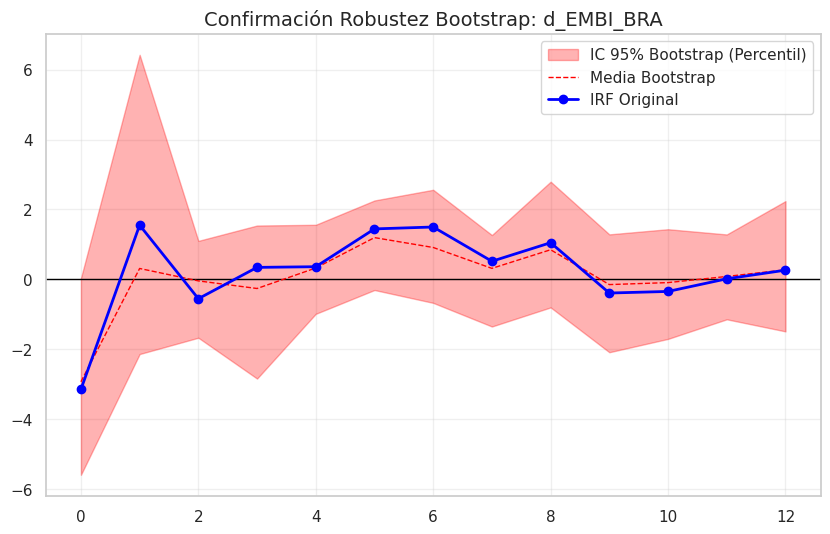

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de Estilo
sns.set_theme(style="whitegrid")

# -------------------------------------------------------------------------
# IMPORTACIÓN ROBUSTA (Para entornos Colab/Jupyter)
# -------------------------------------------------------------------------
try:
    from local_projection_function import estimar_lp
    from test_de_significancia_conjunta import realizar_test_conjunto
    print("✅ Módulos importados correctamente desde archivos (.py).")
except ImportError:
    print("⚠️ Falló importación directa. Intentando buscar funciones en memoria (globals)...")
    if 'estimar_lp' not in globals() or 'realizar_test_conjunto' not in globals():
        print("   ❌ ERROR CRÍTICO: Las funciones 'estimar_lp' y 'realizar_test_conjunto' no están definidas.")
        print("   👉 Ejecuta primero los scripts 'local_projection_function.py' y 'test_de_significancia_conjunta.py'.")
    else:
        print("   ✅ Funciones detectadas en memoria.")

# Definir funciones wrapper si están en globals pero no importadas
if 'estimar_lp' in globals() and 'estimar_lp' not in locals():
    estimar_lp = globals()['estimar_lp']
if 'realizar_test_conjunta' in globals() and 'realizar_test_conjunta' not in locals():
    realizar_test_conjunta = globals()['realizar_test_conjunta']

# -------------------------------------------------------------------------
# HELPER: Estimación SUR Silenciosa para Bootstrap
# -------------------------------------------------------------------------
from linearmodels.system import SUR
import statsmodels.api as sm

def _estimar_sur_params(df, variable_respuesta, shock, controles, h_max):
    """
    Prepara datos y estima SUR para obtener Params y Cov del sistema.
    Retorna: (beta_vec_shock, cov_mat_shock) específico para los coeficientes de interés.
    """
    cols_req = [variable_respuesta, shock] + controles
    df_clean = df.dropna(subset=cols_req).copy()

    # Índices válidos comunes: Debemos asegurar que y_{t+h} existe para h_max
    # Para consistencia en SUR, usamos la MUESTRA COMÚN (intersection).
    # Esto evita el error "array dimensions must match exactly".

    # 1. Definir rango máximo de índices válidos
    # El shift(-h) crea NaNs al final. El peor caso es h_max.
    # El shift(1) del diff crea NaN al principio.

    # Generamos columnas temporales para calcular el índice común exacto
    temp_df = df_clean.copy()
    temp_df['Target_Max'] = temp_df[variable_respuesta].shift(-h_max)
    temp_df['Diff_Lag'] = temp_df[variable_respuesta].shift(1)

    # Dropna en todo lo que vamos a usar
    cols_check = [variable_respuesta, 'Target_Max', 'Diff_Lag', shock] + controles
    valid_iters = temp_df.dropna(subset=cols_check).index

    ecuaciones = {}

    for h in range(h_max + 1):
        # Usamos .loc[valid_iters] para asegurar idéntica longitud

        # LHS
        y_h = df_clean.loc[valid_iters, variable_respuesta].shift(-h) # Ojo: shift sobre slice? No.
        # Mejor: shift sobre full, luego slice.

        y_h_full = df_clean[variable_respuesta].shift(-h)
        y_prev_full = df_clean[variable_respuesta].shift(1)

        lhs = (y_h_full - y_prev_full).loc[valid_iters]
        lhs.name = f"h{h}"

        # RHS
        X = df_clean.loc[valid_iters, [shock] + controles]
        X = sm.add_constant(X)

        # Validación final de integridad (no debería haber NaNs si valid_iters es correcto)
        if lhs.isna().any() or X.isna().any().any():
             # Fallback: si por alguna razón el índice no cuadra, abortamos
             return None, None

        ecuaciones[f'h{h}'] = {'dependent': lhs, 'exog': X}

    # Estimar SUR
    try:
        # Verbose removed
        sistema = SUR(ecuaciones)
        res_sur = sistema.fit(cov_type='kernel', kernel='newey-west')
    except Exception as e:
        print(f"DEBUG: Error interno en SUR.fit(): {e}")
        return None, None

    # Extraer parámetros del shock
    # Nombres esperados: "h0_FF4", "h1_FF4"... o MultiIndex
    params = res_sur.params
    cov = res_sur.cov

    shock_keys = []
    # Detección Robust (igual que en test_conjunto)
    is_multi = isinstance(params.index, pd.MultiIndex)

    if is_multi:
        for idx in params.index:
            if idx[1] == shock: shock_keys.append(idx)
        shock_keys.sort(key=lambda x: int(x[0].replace('h','')))
    else:
        shock_keys = [p for p in params.index if str(p).endswith(f"_{shock}")]
        # Fallback relax
        if not shock_keys:
             shock_keys = [p for p in params.index if shock in str(p)]

        # Ordenar (h0, h1...)
        try:
             shock_keys.sort(key=lambda x: int(x.split('_')[0].replace('h','')))
        except: pass

    if not shock_keys:
        print(f"DEBUG: No se encontraron keys para shock '{shock}'.")
        print(f"DEBUG: Keys disponibles (sample): {list(params.index)[:10]}")
        return None, None

    b_vec = params[shock_keys].values
    v_mat = cov.loc[shock_keys, shock_keys].values

    return b_vec, v_mat

# -------------------------------------------------------------------------
# ALGORITMO MOVING BLOCK BOOTSTRAP
# -------------------------------------------------------------------------

def generar_muestra_bootstrap(df, block_size):
    """
    Genera una nueva muestra remuestreando bloques consecutivos del DF original.
    Preserva la dependencia temporal intra-bloque.
    """
    n_obs = len(df)
    n_blocks = int(np.ceil(n_obs / block_size))

    # Indices posibles de inicio de bloque (1 a T - block_size)
    indices_inicio = np.random.randint(0, n_obs - block_size + 1, size=n_blocks)

    nuevos_indices = []
    for idx in indices_inicio:
        nuevos_indices.extend(range(idx, idx + block_size))

    # Recortar al tamaño original si excede
    nuevos_indices = nuevos_indices[:n_obs]

    # Crear DF reordenado
    df_boot = df.iloc[nuevos_indices].copy()

    # IMPORTANTE: Resetear índice para que las funciones de lags/shifts funcionen secuencialmente
    # Si mantenemos el índice fecha original desordenado, el .shift() podría fallar o usar lógica de tiempo.
    # Al resetear, .shift() usará la posición en el nuevo vector, que es lo correcto para MBB.
    df_boot = df_boot.reset_index(drop=True)

    return df_boot

def ejecutar_bootstrap(df, pais, variable_respuesta, shock, controles_base,
                       lags=6, h_max=12, n_im=500, block_size=24):
    """
    Realiza análisis Moving Block Bootstrap CENTRADO.
    Test de Wald Bootstrap: Compara W_boot_centrado vs W_original.
    """
    print(f"\n🎲 INICIANDO MOVING BLOCK BOOTSTRAP (Centrado)")
    print(f"   B={n_im} | Block Size={block_size} (captura persistencia)")
    print(f"   Modelo: {variable_respuesta} ~ {shock} | Lags={lags}")

    # 0. Preparar Controles
    lista_controles_final = []
    for var in controles_base:
        for p in range(1, lags + 1):
            col_name = f"{var}_lag{p}"
            if col_name not in df.columns:
                df[col_name] = df[var].shift(p)
            lista_controles_final.append(col_name)

    # 1. Estimación Original (Base)
    print("   🔹 Obteniendo Wald Original...")

    # Usamos el helper interno para obtener vector y matriz exacta
    b_orig, v_orig = _estimar_sur_params(df, variable_respuesta, shock, lista_controles_final, h_max)

    if b_orig is None:
        print("❌ Error estimando modelo original. Abortando.")
        return

    # Wald Original: b' V^-1 b
    # (Test H0: Beta=0)
    try:
        v_inv_orig = np.linalg.inv(v_orig)
        wald_stat_orig = b_orig.T @ v_inv_orig @ b_orig
        print(f"   🔹 Wald Stat Original: {wald_stat_orig:.4f}")
    except:
        print("❌ Matriz original singular.")
        return

    # Para graficar (Point Estimate)
    # Requerimos el DF de IRF normal
    # Podemos usar b_orig directamente, sabiendo que son h=0..hmax
    h_steps = np.arange(h_max + 1)

    # 2. Bucle Bootstrap Centrado
    print("   🔄 Iniciando simulaciones...")

    boot_walds_centered = []
    boot_betas = []
    exitos = 0

    from numpy.linalg import LinAlgError

    for i in range(n_im):
        if (i+1) % 100 == 0: print(f"      Simulación {i+1}/{n_im}...")

        # A. Resample
        df_boot = generar_muestra_bootstrap(df, block_size)

        # B. Estimar en muestra bootstrap
        b_boot, v_boot = _estimar_sur_params(df_boot, variable_respuesta, shock, lista_controles_final, h_max)

        if b_boot is None: continue

        # C. Calcular Wald Centrado
        # Test H0: beta_boot_true = beta_orig
        # Stat = (b_boot - b_orig)' V_boot^-1 (b_boot - b_orig)
        try:
            v_inv_boot = np.linalg.inv(v_boot)

            diff = b_boot - b_orig
            w_cent = diff.T @ v_inv_boot @ diff

            boot_walds_centered.append(w_cent)
            boot_betas.append(b_boot)
            exitos += 1

        except LinAlgError:
            continue

    # 3. Resultados e Inferencia
    boot_walds_centered = np.array(boot_walds_centered)
    boot_betas = np.array(boot_betas) # Shape (N, h)

    print(f"\n📊 RESULTADOS FINAL BOOTSTRAP (Válidos: {exitos}/{n_im})")

    # A. P-Value del Wald
    # Proporción de veces que el Wald simulado (bajo H0 verdadera en su mundo)
    # supera al Wald observado en el mundo real (bajo H0 falsa posiblemente).
    # P = Mean( W_cent > W_orig )

    p_value_boot = np.mean(boot_walds_centered > wald_stat_orig)

    # B. Intervalos de Confianza (Percentiles)
    # Regla: Si el IC no contiene el cero persistentemente.
    ci_lower = np.percentile(boot_betas, 2.5, axis=0) # 95%
    ci_upper = np.percentile(boot_betas, 97.5, axis=0)

    print(f"   Estadístico Wald Original: {wald_stat_orig:.4f}")
    print(f"   P-Valor Bootstrap (Centrado): {p_value_boot:.4f}")

    sig_conjunta = p_value_boot < 0.05
    if sig_conjunta:
        print("✅ EL SHOCK ES CONJUNTAMENTE SIGNIFICATIVO (Bootstrap P < 0.05)")
    else:
        print("❌ No se rechaza significancia conjunta (P >= 0.05)")

    # 4. Gráfico
    plt.figure(figsize=(10, 6))

    plt.axhline(0, color='black', linewidth=1)

    # Banda Bootstrap
    plt.fill_between(h_steps, ci_lower, ci_upper, color='red', alpha=0.3, label='IC 95% Bootstrap (Percentil)')

    # Media Bootstrap (para ver sesgo)
    mean_boot = np.mean(boot_betas, axis=0)
    plt.plot(h_steps, mean_boot, color='red', linestyle='--', linewidth=1, label='Media Bootstrap')

    # Original
    plt.plot(h_steps, b_orig, color='blue', linewidth=2, marker='o', label='IRF Original')

    plt.title(f"Confirmación Robustez Bootstrap: {variable_respuesta}", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def match_title(var):
    if 'Actividad' in var: return "Actividad Económica"
    if 'EMBI' in var: return "EMBI"
    if 'TCR' in var: return "TCR"
    return var

# -----------------------------------------------------------
# EJECUCIÓN DE EJEMPLO
# -----------------------------------------------------------
if __name__ == "__main__":
    if 'df_transformado' in locals():
        # Ejemplo Chile con 6 lags (modelo robusto seleccionado)
        vars_base_chile = ['d_log_Actividad_BRA','d_EMBI_BRA','d_log_TCR_BRA'] # Ajustar según usuario

        # Ejecutar
        ejecutar_bootstrap(globals()['df_transformado'],
                           pais='Brasil',
                           variable_respuesta='d_EMBI_BRA',
                           shock='FF4',
                           controles_base=vars_base_chile, # OJO: Definir bien las bases
                           lags=6,
                           h_max=12,
                           n_im=50, # 500 es lento para test, pongo 50 en ejemplo. Usuario pondrá 500.
                           block_size=24)
    else:
        print("⚠️ 'df_transformado' no encontrado.")
